<a href="https://colab.research.google.com/github/pachterlab/CBP_2021/blob/main/notebooks/combinedFigurePlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Thu Sep  9 19:23:25 UTC 2021


In [1]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (542/542), done.
remote: Compressing objects: 100% (497/497), done.
remote: Total 542 (delta 328), reused 86 (delta 25), pack-reused 0
Receiving objects: 100% (542/542), 80.56 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [2]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn
!pip3 install --quiet scvi-tools

     |████████████████████████████████| 127 kB 33.4 MB/s 
     |████████████████████████████████| 7.7 MB 28.2 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 217 kB 28.6 MB/s 
     |████████████████████████████████| 211 kB 47.2 MB/s 
     |████████████████████████████████| 678 kB 39.4 MB/s 
     |████████████████████████████████| 813 kB 39.9 MB/s 
     |████████████████████████████████| 244 kB 57.8 MB/s 
     |████████████████████████████████| 636 kB 72.4 MB/s 
     |████████████████████████████████| 282 kB 54.8 MB/s 
     |████████████████████████████████| 829 kB 46.7 MB/s 
     |████████████████████████████████| 119 kB 55.9 MB/s 
     |████████████████████████████████| 1.3 MB 42.3 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 142 kB 61.4 MB/s 
     |██████████████

In [3]:
%cd /content/CBP_2021/data
!gunzip *.gz

/content/CBP_2021/data


In [4]:
%cd /content/CBP_2021/scripts

/content/CBP_2021/scripts


## **Install Packages**

In [7]:
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML #Now has continuous label addition
import visualizations as vis

import random
import scvi
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [6]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../data'

pcs = 50
n_latent = 50

### **Correlation Metric Plots for Fig. 1**

In [ ]:
uteroCorrs = pd.read_csv(data_path+'/exUtElMapVals.csv')
smartCorrs = pd.read_csv(data_path+'/smartSeqElVals.csv')
merCorrs = pd.read_csv(data_path+'/merfishElVals.csv') 
smartCorrs.head()

,Unnamed: 0,Latent,Distance,Pearsonr,Dimension
0,0,Elephant,Inter-Type,0.407403,MCML 2D
1,1,Elephant,Intra-Sex,-0.113936,MCML 2D
2,2,Elephant,Intra-Type,-0.192708,MCML 2D
3,3,Elephant,Inter-Sex,-0.008465,MCML 2D
4,4,Elephant,Inter-Type,0.361200,MCML 2D


In [ ]:
avgs = {}
for i in ['PCA TSNE', 'PCA UMAP','PCA 2D']:
  avgs[i] = [np.mean(uteroCorrs['Pearsonr'][uteroCorrs['Latent'].isin([i]) & uteroCorrs['Distance'].isin(['Inter-Type'])]),np.mean(uteroCorrs['Pearsonr'][uteroCorrs['Latent'].isin([i]) & uteroCorrs['Distance'].isin(['Intra-Type'])])]
print(avgs)

# % increase in intra-type for map, elephant, and elephant merfish
diffs = {}
for i in ['Elephant', 'Map']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(uteroCorrs['Pearsonr'][uteroCorrs['Latent'].isin([i]) & uteroCorrs['Distance'].isin(['Intra-Type'])])
  diffs[i] = [(a-tsne)/tsne, (a-umap)/umap]

print(diffs)


# % increase from PCA to t-SNE or UMAP from max value otherwise
pcadiffs = {}
for i in ['PCA 2D']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(uteroCorrs['Pearsonr'][uteroCorrs['Latent'].isin([i]) & uteroCorrs['Distance'].isin(['Intra-Type'])])
  pcadiffs[i] = [(a-tsne)/tsne, (a-umap)/umap]

print(pcadiffs)



{'PCA TSNE': [0.5090758085731696, 0.0967989024141898], 'PCA UMAP': [0.43585920346034596, 0.10002407830105098], 'PCA 2D': [0.8966362465896367, 0.9126031168590746]}
{'Elephant': [2.1922991399218827, 2.0893666622165066], 'Map': [3.209448310946537, 3.073718880392908]}
{'PCA 2D': [8.427825048616416, 8.123834304299564]}


In [ ]:
avgs = {}
for i in ['PCA TSNE', 'PCA UMAP','PCA 2D']:
  avgs[i] = [np.mean(smartCorrs['Pearsonr'][smartCorrs['Latent'].isin([i]) & smartCorrs['Distance'].isin(['Inter-Type'])]),np.mean(smartCorrs['Pearsonr'][smartCorrs['Latent'].isin([i]) & smartCorrs['Distance'].isin(['Intra-Type'])])]
print(avgs)

# % increase in intra-type for map, elephant, and elephant merfish
diffs = {}
for i in ['Elephant']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(smartCorrs['Pearsonr'][smartCorrs['Latent'].isin([i]) & smartCorrs['Distance'].isin(['Intra-Type'])])
  diffs[i] = [(a-tsne)/tsne, (a-umap)/umap]

print(diffs)


# % increase from PCA to t-SNE or UMAP from max value otherwise
pcadiffs = {}
for i in ['PCA 2D']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(smartCorrs['Pearsonr'][smartCorrs['Latent'].isin([i]) & smartCorrs['Distance'].isin(['Intra-Type'])])
  pcadiffs[i] = [(a-tsne)/tsne, (a-umap)/umap]

print(pcadiffs)


{'PCA TSNE': [0.4811336893352909, 0.10525224879550768], 'PCA UMAP': [0.5235970556139125, 0.20676150508944557], 'PCA 2D': [0.8213495818503362, 0.24220836999423115]}
{'Elephant': [-0.08219185457695109, -0.5327884113301448]}
{'PCA 2D': [1.3012180049930577, 0.17143841591524092]}


In [ ]:
#MERFISH data
avgs = {}
for i in ['PCA TSNE', 'PCA UMAP','PCA 2D']:
  avgs[i] = [np.mean(merCorrs['Pearsonr'][merCorrs['Latent'].isin([i]) & merCorrs['Distance'].isin(['Inter-Type'])]),np.mean(merCorrs['Pearsonr'][merCorrs['Latent'].isin([i]) & merCorrs['Distance'].isin(['Intra-Type'])])]
print(avgs)

# % increase in intra-type for map, elephant, and elephant merfish
diffs = {}
for i in ['Elephant']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(merCorrs['Pearsonr'][merCorrs['Latent'].isin([i]) & merCorrs['Distance'].isin(['Intra-Type'])])
  diffs[i] = [(tsne-a)/tsne, (umap-a)/umap]

print(diffs)


# % increase from PCA to t-SNE or UMAP from max value otherwise
pcadiffs = {}
for i in ['PCA 2D']:
  tsne = avgs['PCA TSNE'][1]
  umap = avgs['PCA UMAP'][1]

  a = np.mean(merCorrs['Pearsonr'][merCorrs['Latent'].isin([i]) & merCorrs['Distance'].isin(['Intra-Type'])])
  pcadiffs[i] = [(tsne-a)/tsne, (umap-a)/umap]

print(pcadiffs)


{'PCA TSNE': [0.5723630809083327, -0.0875910125373706], 'PCA UMAP': [0.5193058248610753, -0.12267646300679469], 'PCA 2D': [0.6178182436104247, 0.8714586152710362]}
{'Elephant': [4.607676419001896, 3.575881491057246]}
{'PCA 2D': [10.949178460509625, 8.103714876608144]}


In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP','PCA 50D','Flower']
uteroCorrs = uteroCorrs[~uteroCorrs['Latent'].isin(toRemove)]
subuteroCorrs = uteroCorrs[~uteroCorrs['Latent'].isin(['Map'])]
smartCorrs = smartCorrs[~smartCorrs['Latent'].isin(toRemove)]
merCorrs = merCorrs[~merCorrs['Latent'].isin(toRemove)]

In [ ]:
toRemove = ['Intra-Sex','Inter-Sex']
smartCorrs = smartCorrs[~smartCorrs['Distance'].isin(toRemove)]

In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
subuteroCorrs['Latent'] = [x.replace('PCA TSNE', 'PCA t-SNE') for x in subuteroCorrs['Latent']]
smartCorrs['Latent'] = [x.replace('PCA TSNE', 'PCA t-SNE') for x in smartCorrs['Latent']]

maputeroCorrs = uteroCorrs[~uteroCorrs['Latent'].isin(['Elephant'])]
maputeroCorrs['Latent'] = [x.replace('PCA TSNE', 'PCA t-SNE') for x in maputeroCorrs['Latent']]

merCorrs['Latent'] = [x.replace('PCA TSNE', 'PCA t-SNE') for x in merCorrs['Latent']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
pd.concat([subuteroCorrs,maputeroCorrs]).head()


,Unnamed: 0,Latent,Distance,Pearsonr,Dimension
10,10,Elephant,Inter-Type,0.436086,MCML 2D
11,11,Elephant,Intra-Type,0.398849,MCML 2D
12,12,Elephant,Inter-Type,0.372641,MCML 2D
13,13,Elephant,Intra-Type,0.259190,MCML 2D
14,14,Elephant,Inter-Type,0.581620,MCML 2D


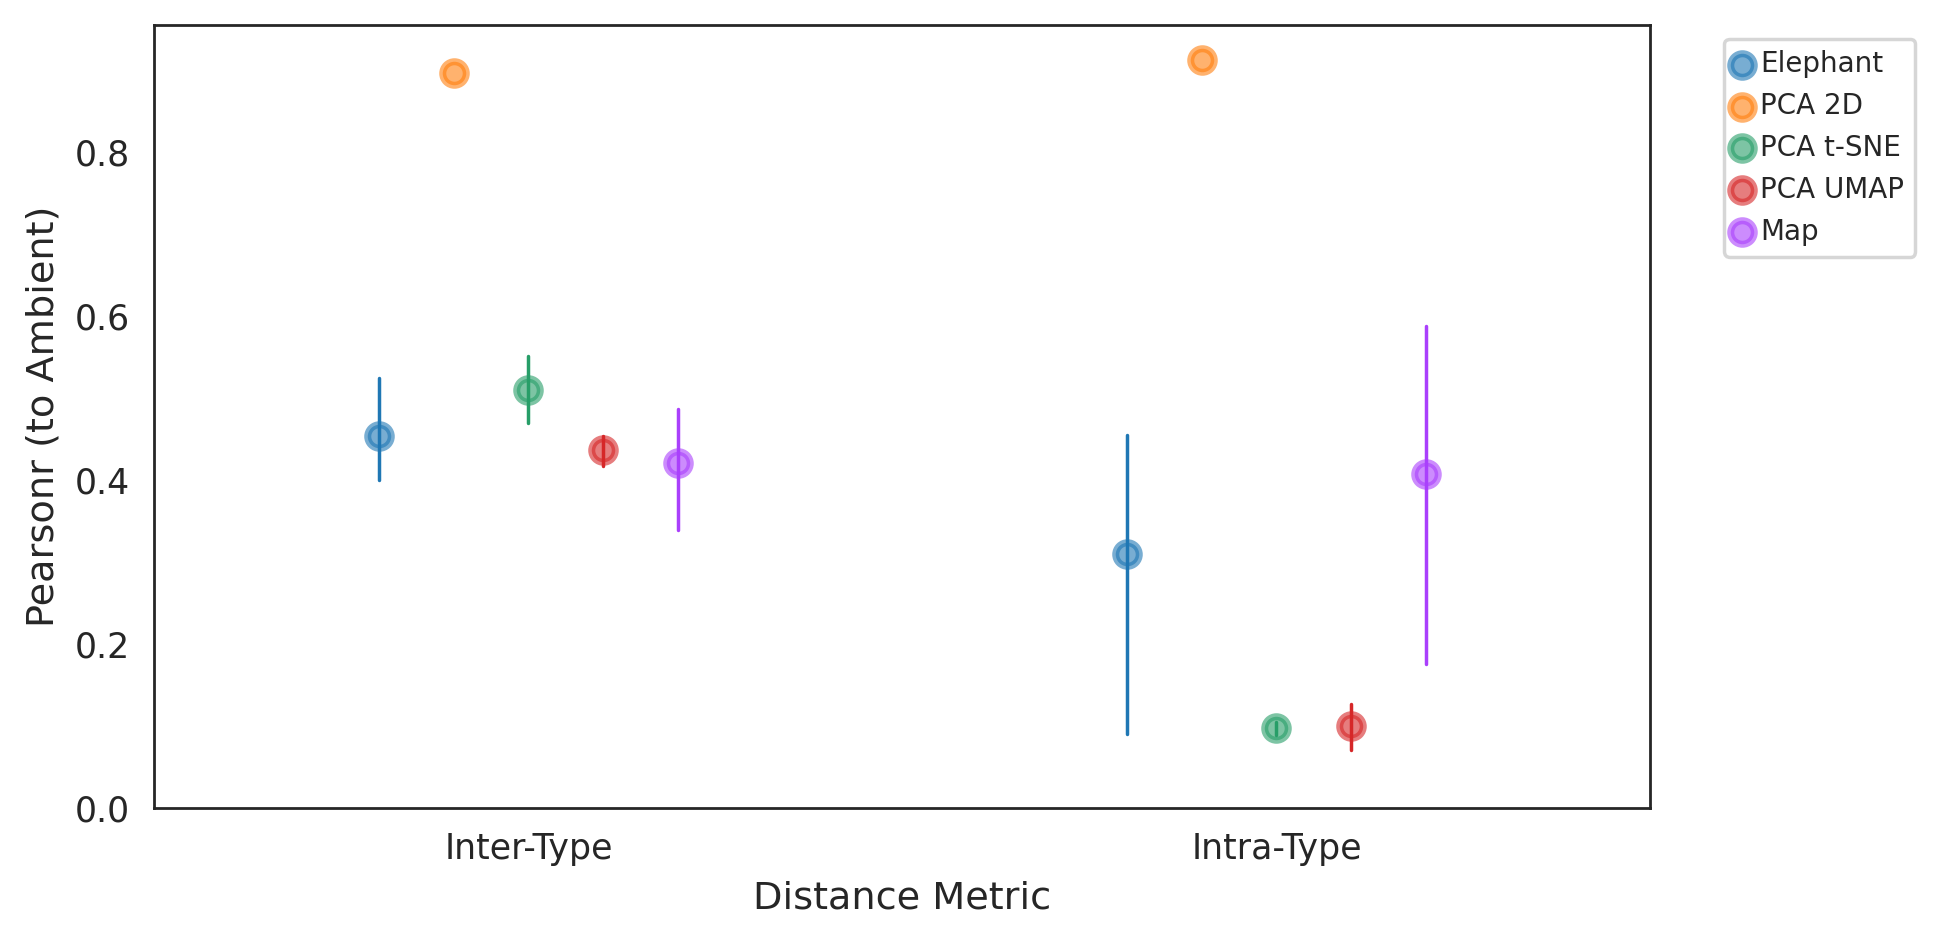

In [ ]:
#Combine elephant and map from ex utero E8.5 day data


plt.figure(figsize=figsize)
g=sns.pointplot(x='Distance', y='Pearsonr', data=pd.concat([subuteroCorrs,maputeroCorrs]), hue='Latent', palette={"Elephant":sns.color_palette()[0],"Map":sns.color_palette()[4],
                  "PCA 2D":sns.color_palette()[1],"PCA t-SNE":sns.color_palette()[2],"PCA UMAP":sns.color_palette()[3]} ,err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Distance Metric",fontsize=axisFontSize)
plt.ylabel("Pearsonr (to Ambient)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

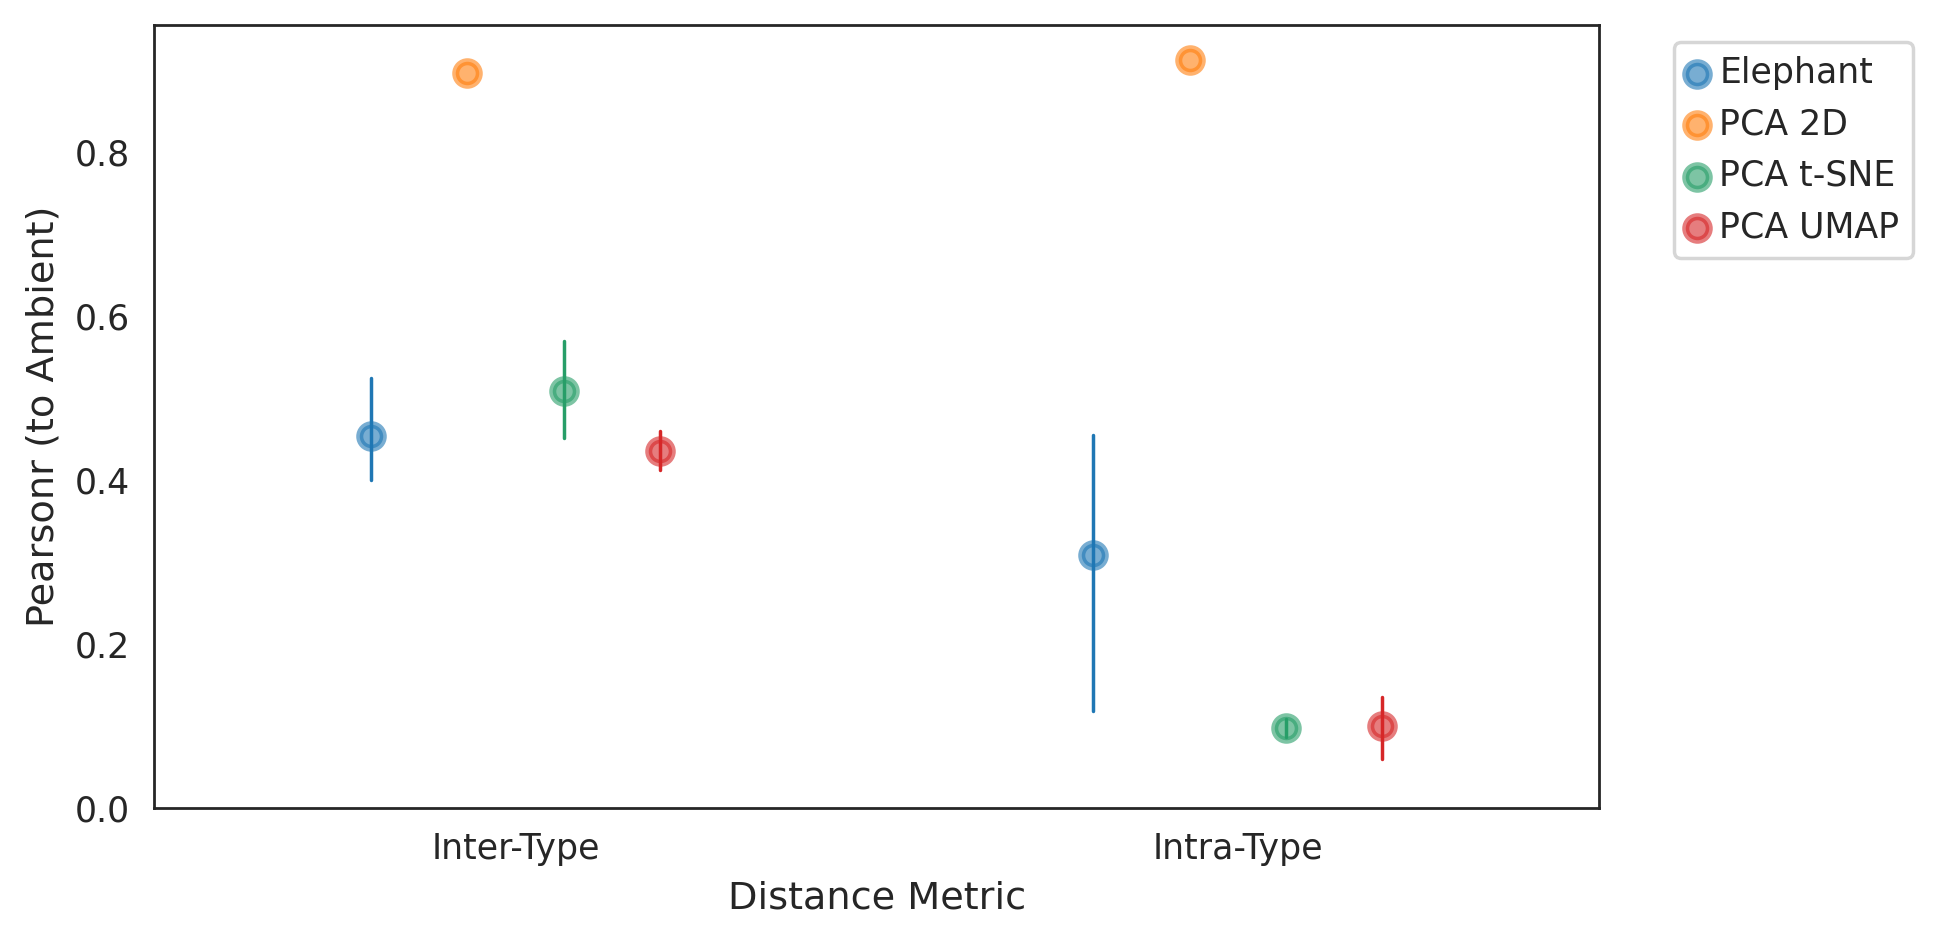

In [ ]:
vis.plotLatentStats(subuteroCorrs, axisFontSize = 11, tickFontSize = 10)

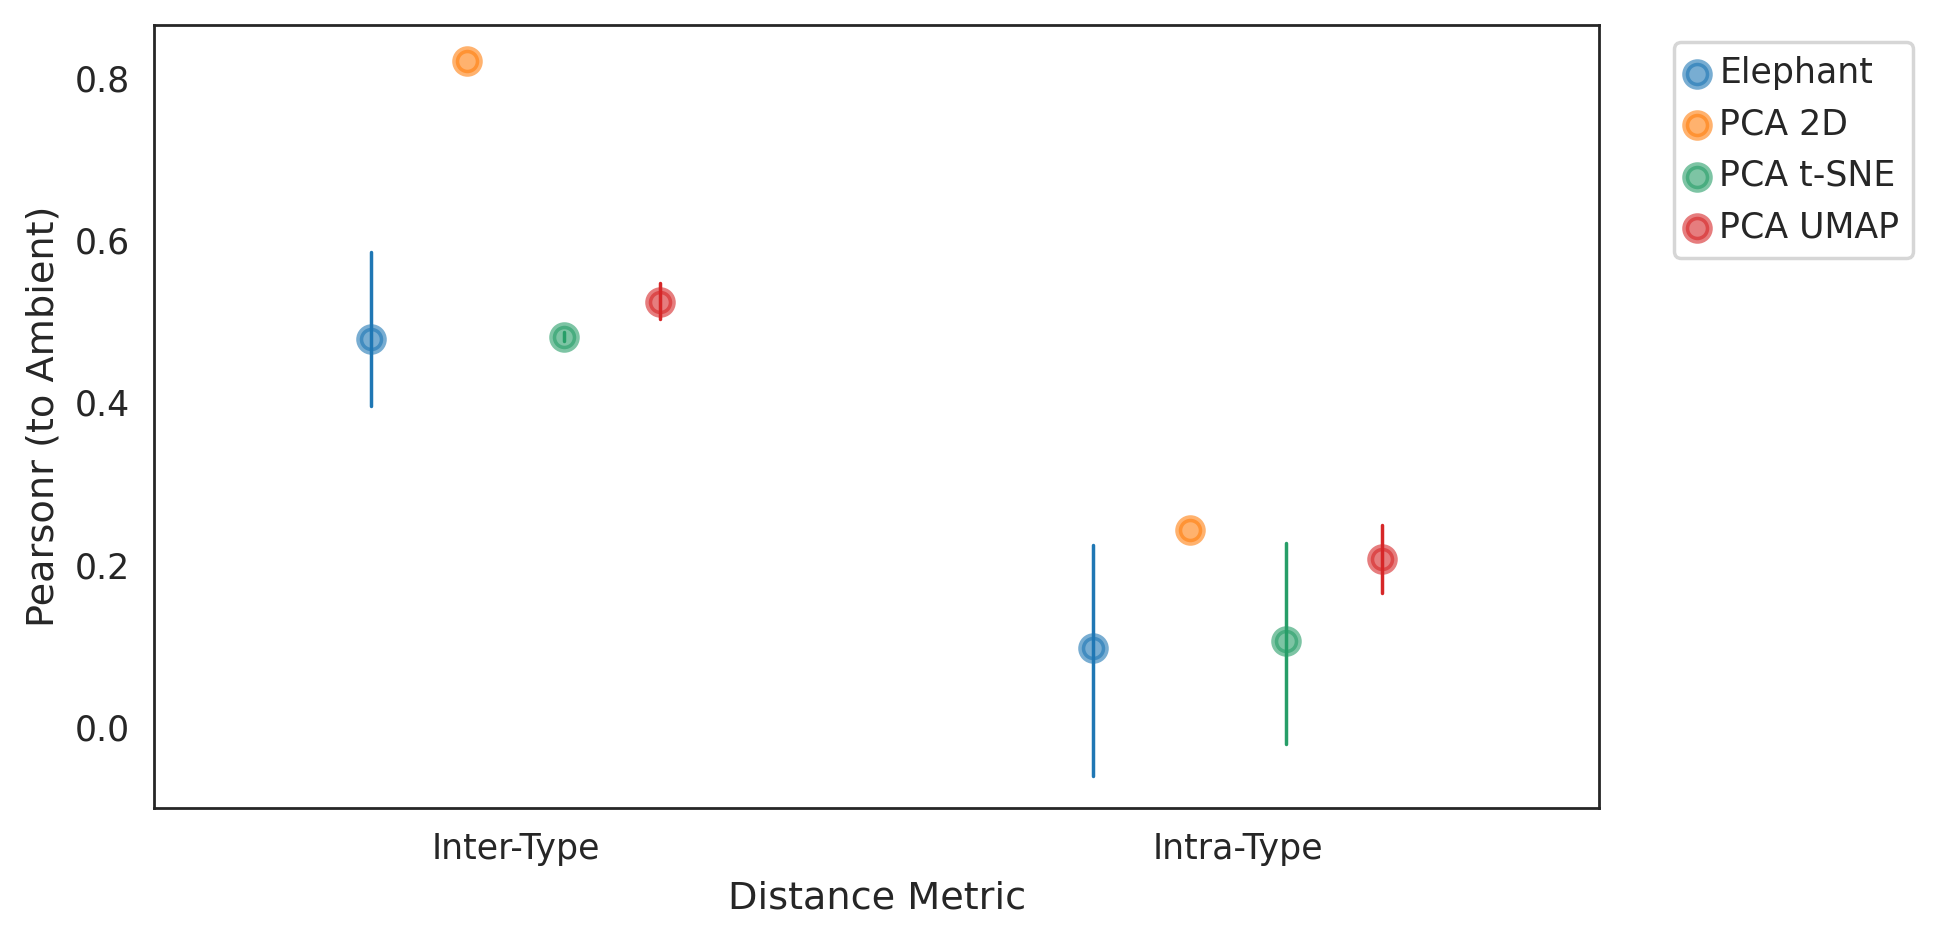

In [ ]:
vis.plotLatentStats(smartCorrs, axisFontSize = 11, tickFontSize = 10,ymin = -0.1)

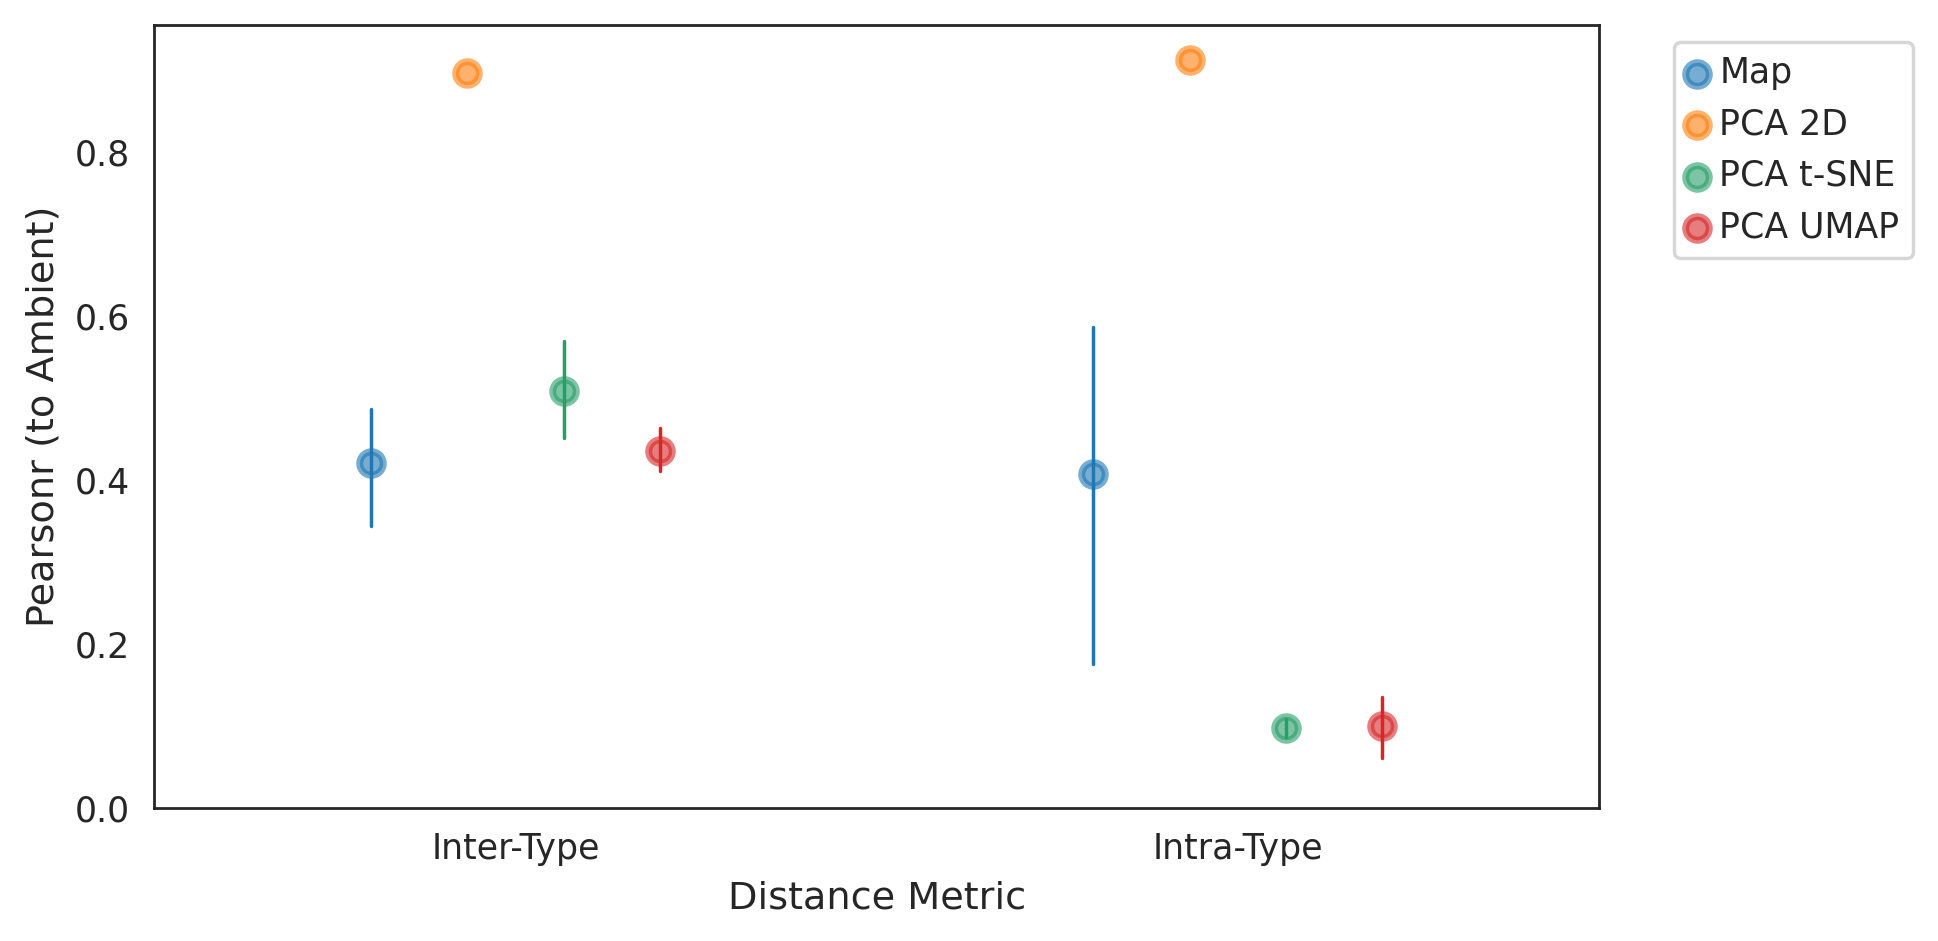

In [ ]:
#Redo with ylim
vis.plotLatentStats(maputeroCorrs, axisFontSize = 11, tickFontSize = 10)

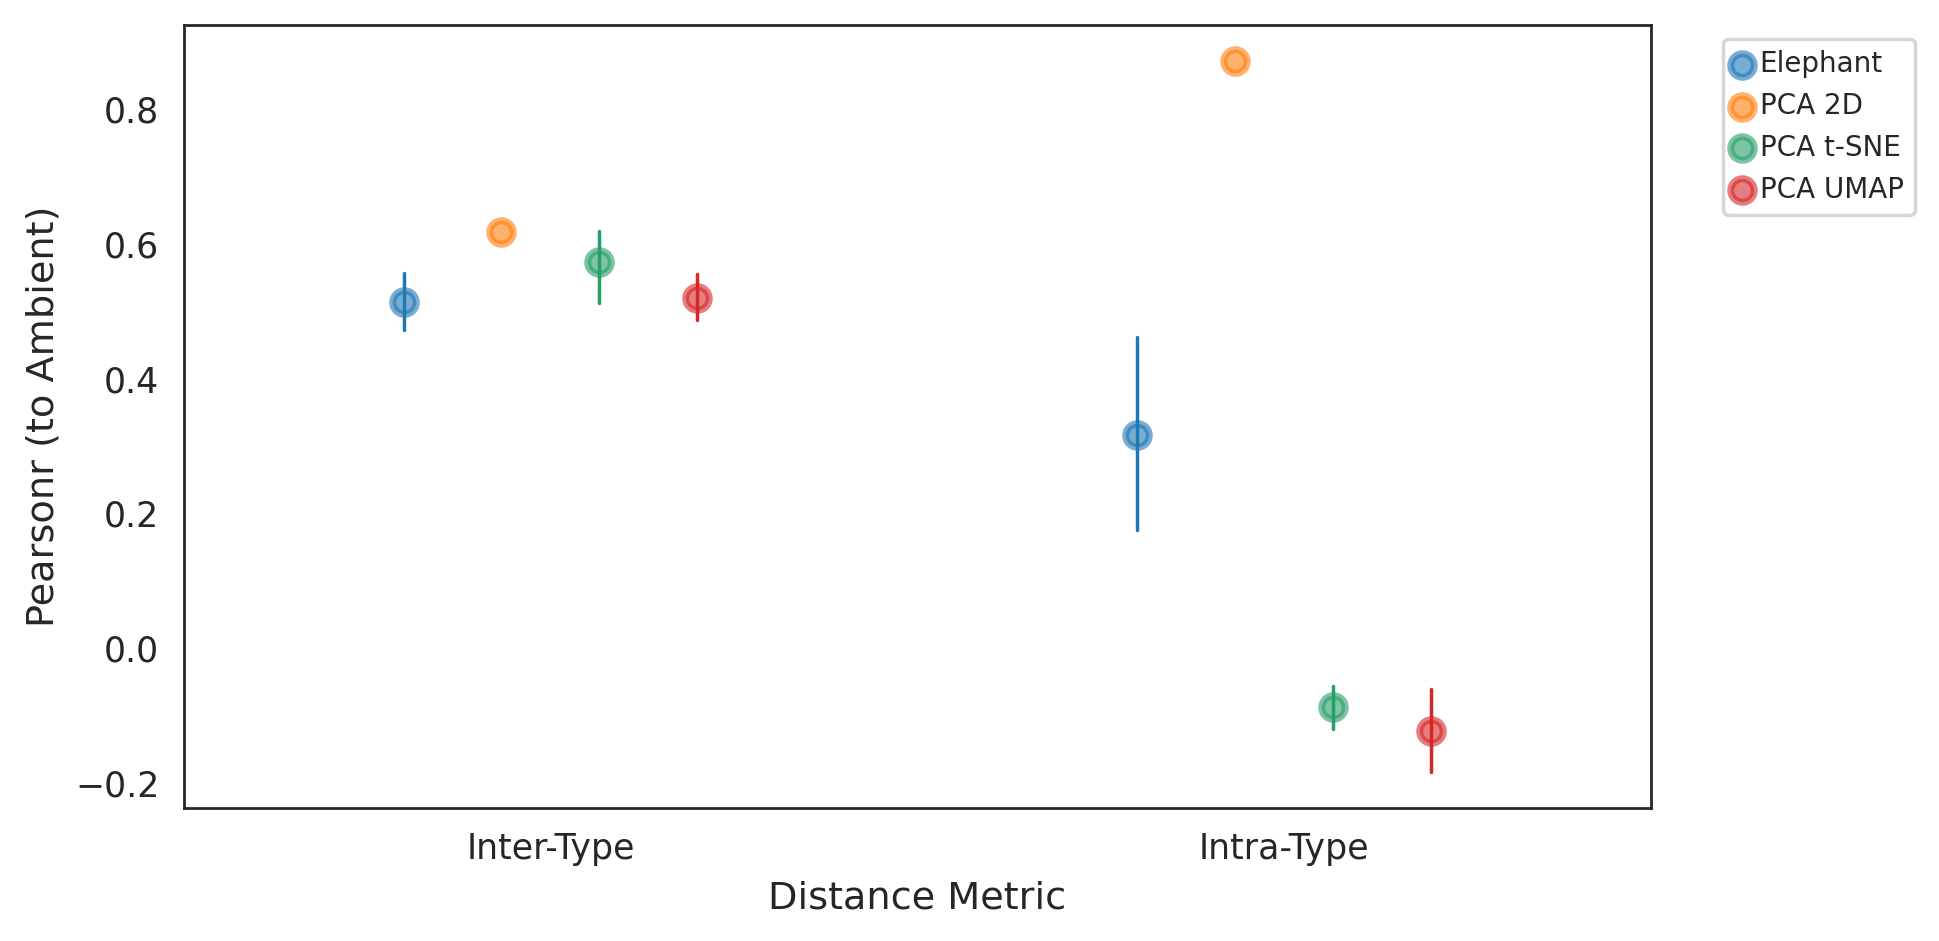

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Distance', y='Pearsonr', data=merCorrs, hue='Latent', palette={"Elephant":sns.color_palette()[0],"Map":sns.color_palette()[4],
                  "PCA 2D":sns.color_palette()[1],"PCA t-SNE":sns.color_palette()[2],"PCA UMAP":sns.color_palette()[3]} ,err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})



plt.xlabel("Distance Metric",fontsize=axisFontSize)
plt.ylabel("Pearsonr (to Ambient)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

In [ ]:
#Make correct label names for densVis methods also (densSNE --> dens-SNE)
test= maputeroCorrs
test.head()

,Unnamed: 0,Latent,Distance,Pearsonr,Dimension
0,0,Map,Inter-Type,0.448019,MCML 2D
1,1,Map,Intra-Type,-0.055902,MCML 2D
2,2,Map,Inter-Type,0.278582,MCML 2D
3,3,Map,Intra-Type,0.683312,MCML 2D
4,4,Map,Inter-Type,0.516837,MCML 2D


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, se

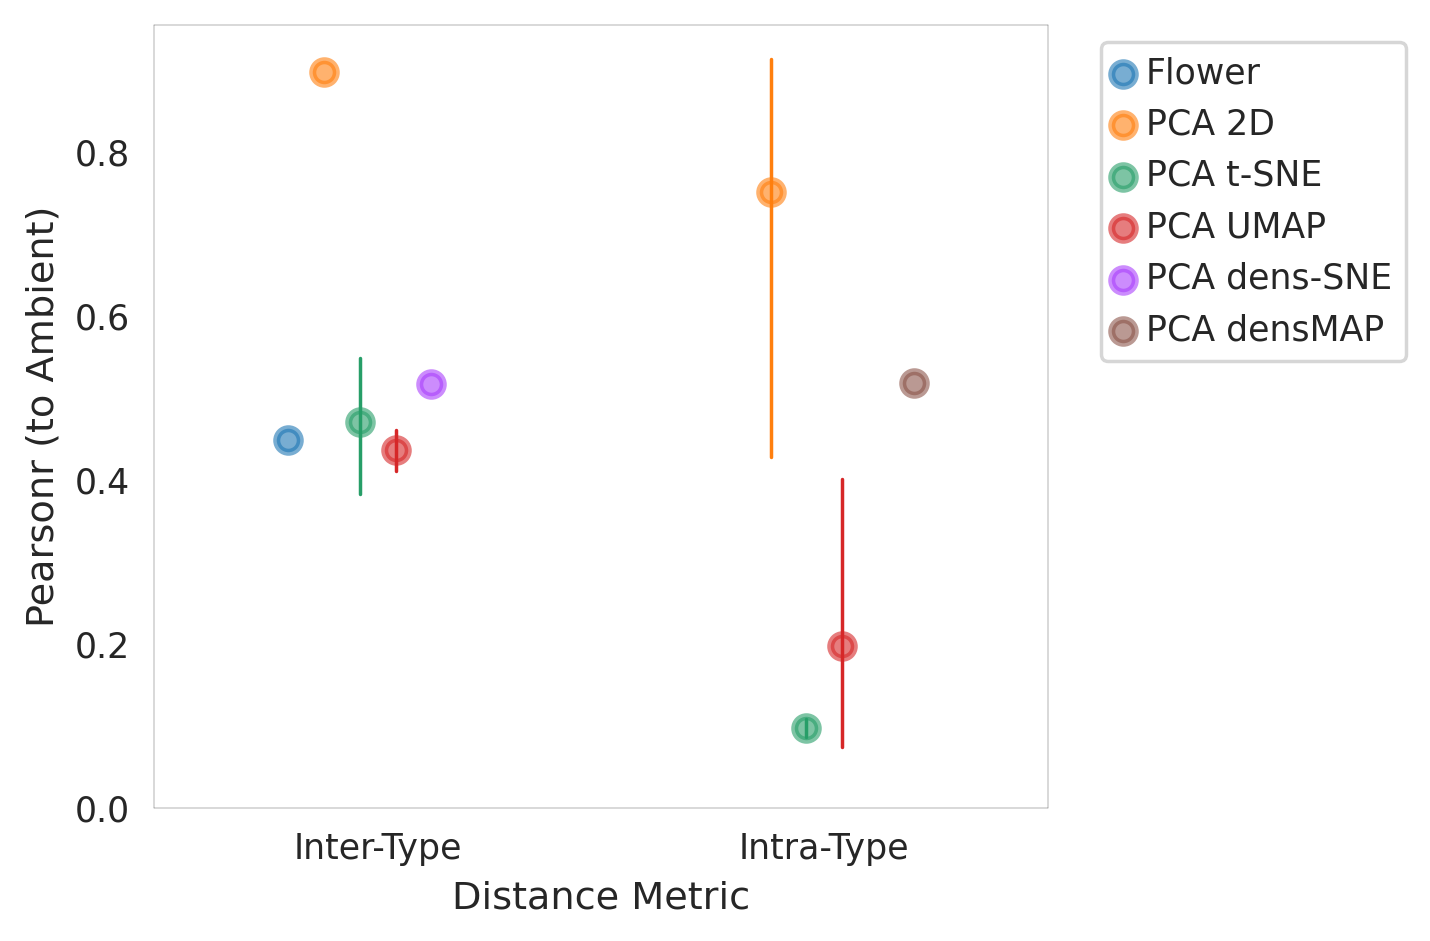

In [ ]:
test['Latent'][0:6] = ['Flower','PCA 2D','PCA t-SNE','PCA UMAP','PCA dens-SNE','PCA densMAP']
test = test[~test['Latent'].isin(['Map'])]
vis.plotLatentStats(test, axisFontSize = 11, tickFontSize = 10,figsize =(6,4))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, se

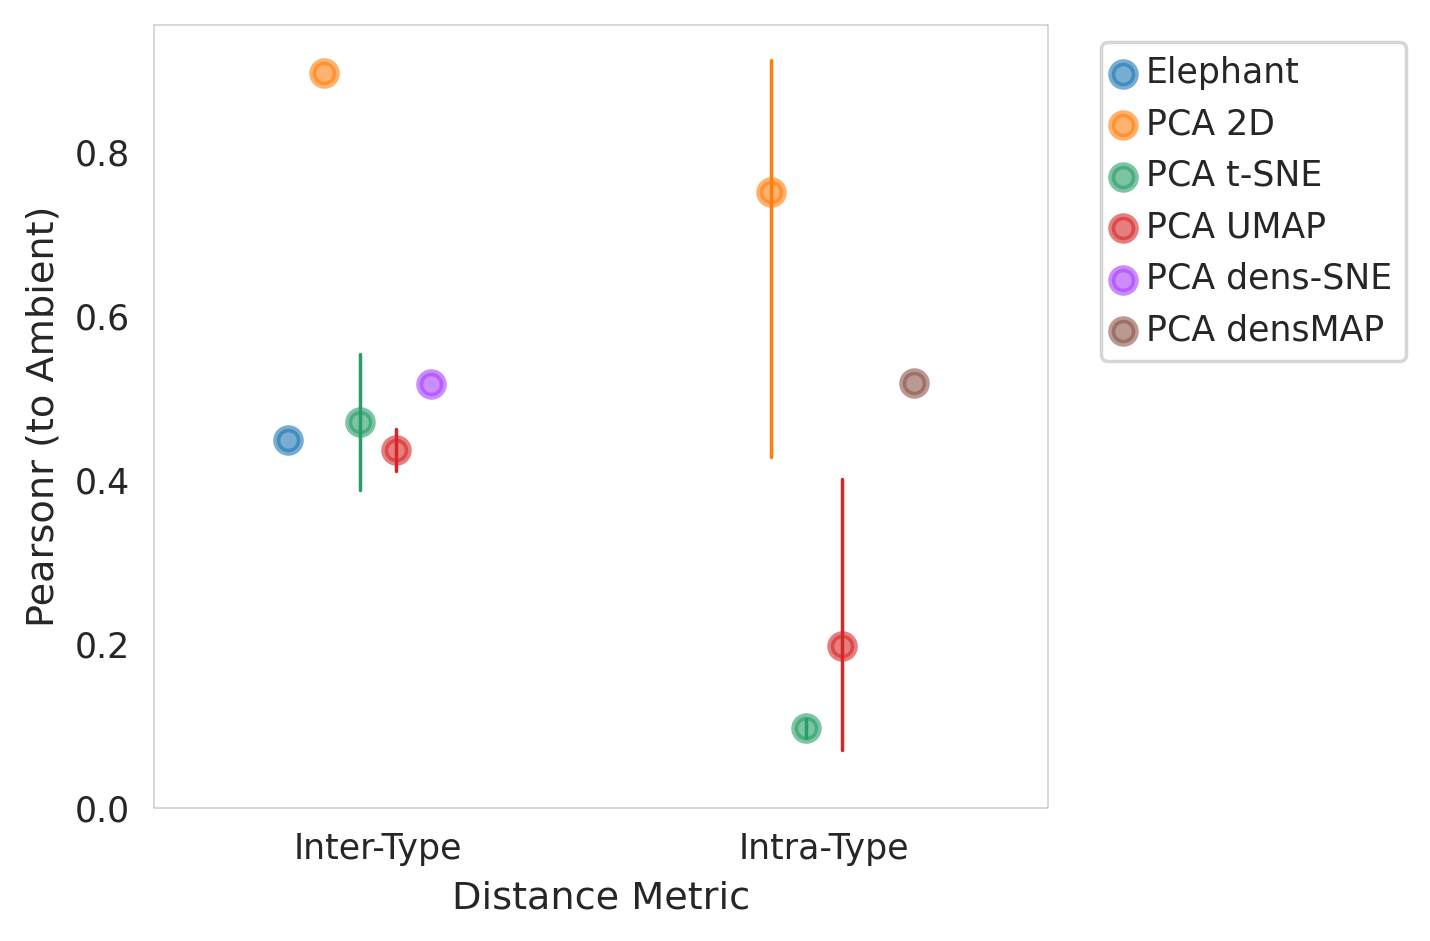

In [ ]:
test['Latent'][0:6] = ['Elephant','PCA 2D','PCA t-SNE','PCA UMAP','PCA dens-SNE','PCA densMAP']
test = test[~test['Latent'].isin(['Map'])]
vis.plotLatentStats(test, axisFontSize = 11, tickFontSize = 10,figsize =(6,4))

### **Prediction Accuracy Plots for Cell Type Label Prediction Fig. 2**

In [8]:
smartPreds = pd.read_csv(data_path+'/allSmartSeqPreds.csv')
netAEpreds = pd.read_csv(data_path+'/netAESmartSeqPreds.csv')
tenxpreds = pd.read_csv(data_path+'/all10XPreds.csv')
matlaspreds = pd.read_csv(data_path+'/allLaMannoPreds0712.csv')

tenxpreds.head()

,Unnamed: 0,Accuracy,Embed,Label
0,0,0.793250,LDVAE,CellType1
1,1,0.791246,LDVAE,CellType1
2,2,0.789642,LDVAE,CellType1
3,3,0.791085,SCANVI,CellType1
4,4,0.792689,SCANVI,CellType1


In [9]:
netAEpreds.head()

,Unnamed: 0,Accuracy,Embed,Label
0,0,0.775966,netAE,CellType1
1,1,0.918455,netAE,Gender2


Get statistics on differences between methods

In [10]:
# % Avg Increase in accuracy by Cell Type MCML (NCA-Recon MCML)
avgMCML = np.mean(smartPreds['Accuracy'][smartPreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(smartPreds['Accuracy'][smartPreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg

percs['netAE'] = (avgMCML - netAEpreds.Accuracy[0])/netAEpreds.Accuracy[0]
print(percs)

#tenx data
avgMCML = np.mean(tenxpreds['Accuracy'][tenxpreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(tenxpreds['Accuracy'][tenxpreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg


print(percs)


#developing brain data
avgMCML = np.mean(matlaspreds['Accuracy'][matlaspreds['Embed'].isin(['NCA-Recon MCML'])])
percs = {}
for i in ['LDVAE','SCANVI','Recon MCML','PCA 50D','PCA UMAP Sup.','PCA UMAP','PCA t-SNE']:
  avg = np.mean(matlaspreds['Accuracy'][matlaspreds['Embed'].isin([i])])
  percs[i] = (avgMCML - avg)/avg

print(percs)


{'LDVAE': 0.017879738169281227, 'SCANVI': 0.012199792041766471, 'Recon MCML': -0.0067106887708360775, 'PCA 50D': -0.004787262526550609, 'PCA UMAP Sup.': 0.004124606546532774, 'PCA UMAP': 0.03932142495711097, 'PCA t-SNE': 0.05172805848961584, 'netAE': 0.1468897785951327}
{'LDVAE': 0.03598443909947382, 'SCANVI': 0.02458294184504268, 'Recon MCML': -0.003827071411435752, 'PCA 50D': 0.009041741248825322, 'PCA UMAP Sup.': 0.13713619169864344, 'PCA UMAP': 0.28703080274422904, 'PCA t-SNE': 0.1521759686985722}
{'LDVAE': -0.05019154098335372, 'SCANVI': -0.02420760317118347, 'Recon MCML': 0.10375802711776827, 'PCA 50D': 0.10116509863460293, 'PCA UMAP Sup.': 0.37706361244204717, 'PCA UMAP': 0.4372864210224966, 'PCA t-SNE': 0.28107516233698043}


In [11]:
#max accuracies
print(max(smartPreds['Accuracy']))
print(max(tenxpreds['Accuracy']))
print(max(matlaspreds['Accuracy']))

0.9160173159999999
0.922885772
0.5892152620000001


In [12]:
allPreds = pd.concat([smartPreds, netAEpreds,tenxpreds,matlaspreds])

In [13]:
dataset = ['SmartSeq Mouse VMH Neurons']*(len(smartPreds)+len(netAEpreds)) + ['10X Mouse VMH Neurons']*len(tenxpreds) + ['10X Developing Mouse Brain']*len(matlaspreds)
allPreds['Dataset'] = dataset

In [14]:
allPreds.head()

,Unnamed: 0,Accuracy,Embed,Label,Dataset
0,0,0.844156,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
1,1,0.867532,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
2,2,0.862338,LDVAE,CellType1,SmartSeq Mouse VMH Neurons
3,3,0.869264,SCANVI,CellType1,SmartSeq Mouse VMH Neurons
4,4,0.867532,SCANVI,CellType1,SmartSeq Mouse VMH Neurons


In [15]:
subAllPreds = allPreds[allPreds.Label == 'CellType1']
subAllPreds = subAllPreds[~(subAllPreds.Embed == 'NCA 100% MCML')]

In [16]:
axisFontSize = 9
tickFontSize = 7
errwidth=1
figsize =(7,3)
dodge=0.4

In [17]:
subAllPreds['Embed'] = [i.replace('NCA-Recon MCML','Cell Type MCML 50D') for i in subAllPreds['Embed']] 

In [18]:
subAllPreds['Embed'] = [i.replace('Recon MCML','Recon MCML 50D') for i in subAllPreds['Embed']] 

In [19]:
subAllPreds['Dataset'] = [i.replace('SmartSeq Mouse VMH Neurons','SMART-seq Mouse VMH Neurons\n(3,850 cells)') for i in subAllPreds['Dataset']] 
subAllPreds['Dataset'] = [i.replace('10X Mouse VMH Neurons','10x Mouse VMH Neurons\n(41,580 cells)') for i in subAllPreds['Dataset']] 
subAllPreds['Dataset'] = [i.replace('10X Developing Mouse Brain','10x Developing Mouse Brain\n(292,495 cells)') for i in subAllPreds['Dataset']] 

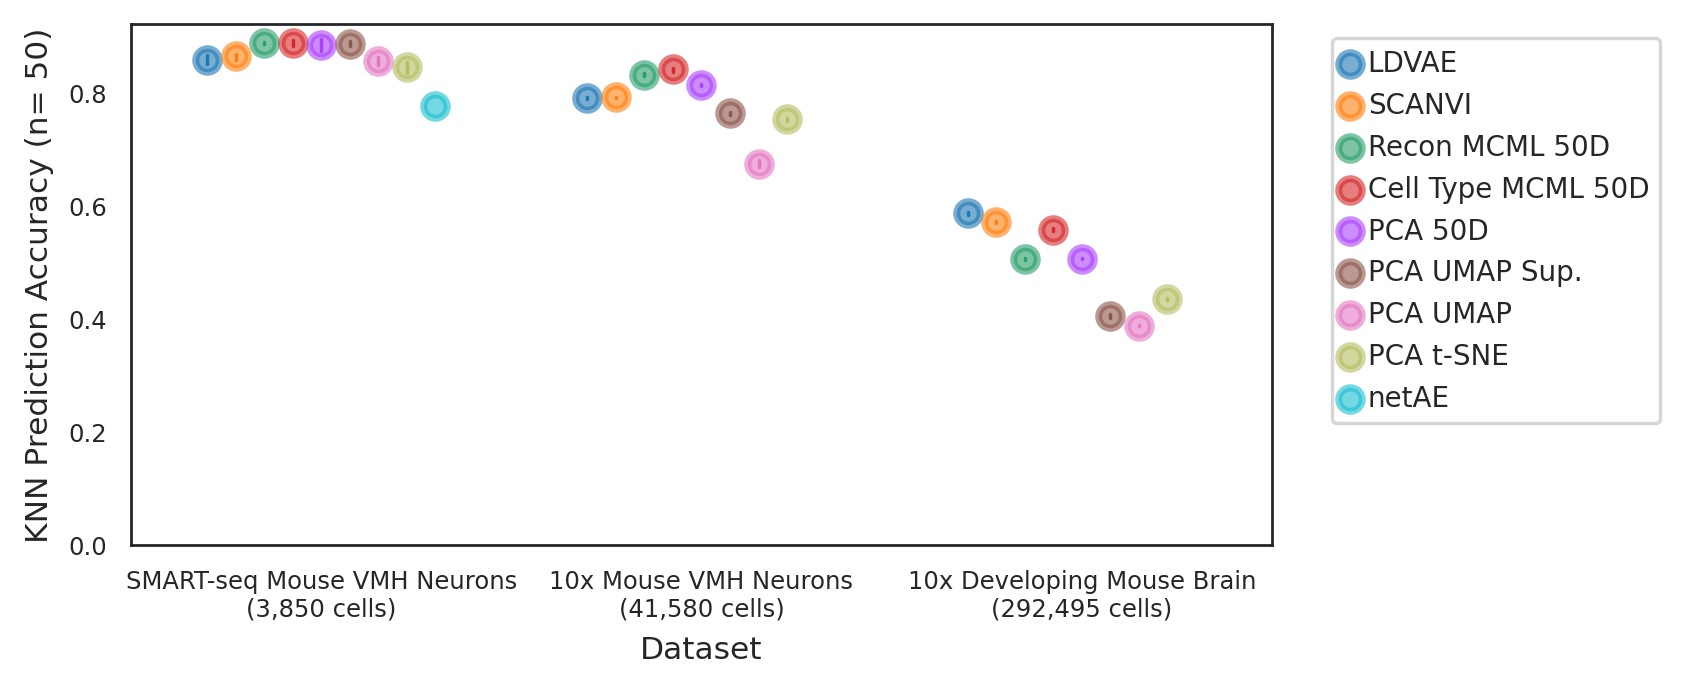

In [21]:
#Maybe add number of cells below
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Accuracy', data=subAllPreds, hue='Embed', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=0.6)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n= 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

In [22]:
subAllPreds2 = subAllPreds[~subAllPreds['Embed'].isin(['PCA UMAP Sup.','PCA UMAP','PCA t-SNE'])]

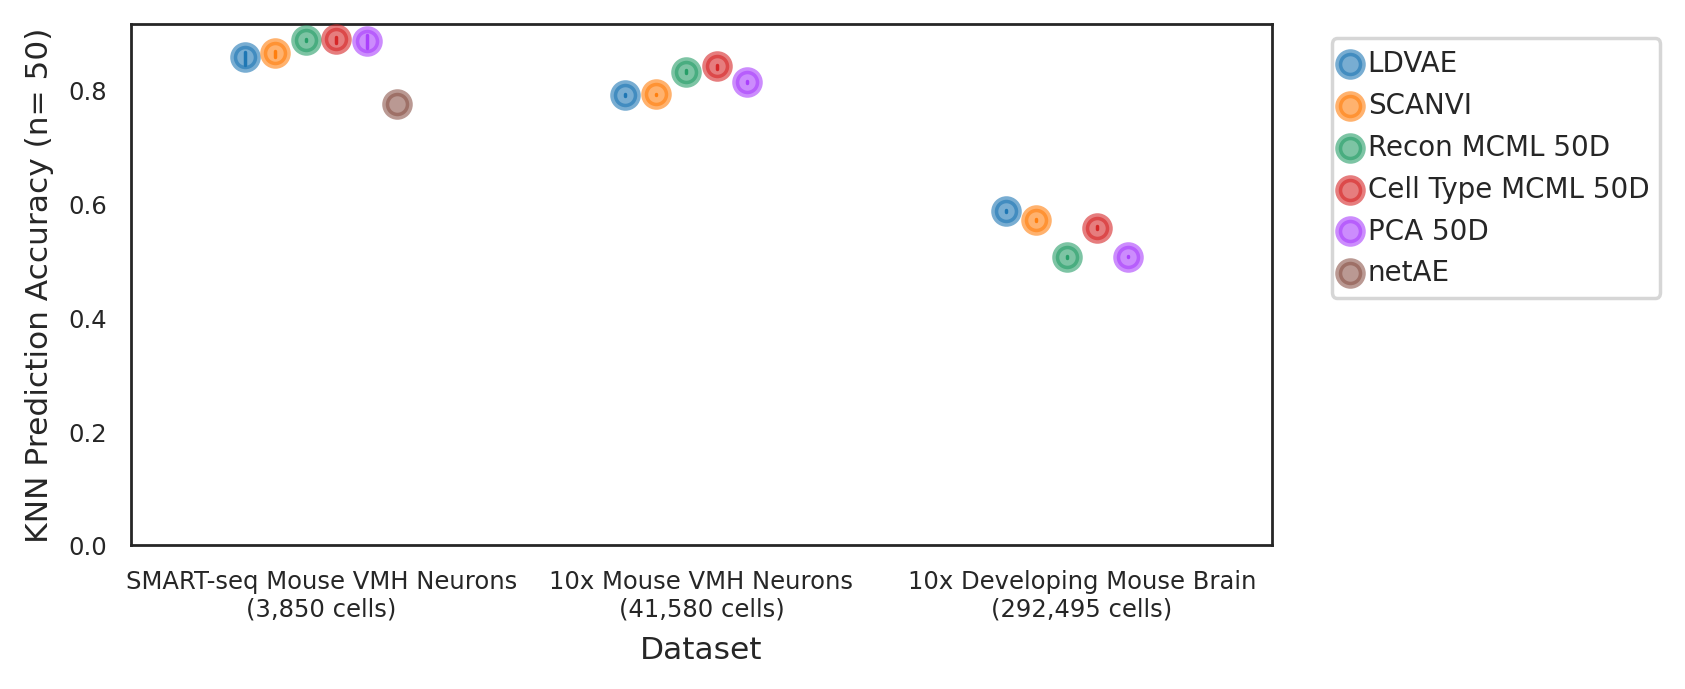

In [23]:
#Maybe add number of cells below
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Accuracy', data=subAllPreds2, hue='Embed', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n= 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

### **Prediction Accuracy of NCA-MCML with Reduced Fraction of Labeled Data**

In [ ]:
smartPreds = pd.read_csv(data_path+'/lowPercsSmartSeqPreds.csv')
tenxpreds = pd.read_csv(data_path+'/lowPercs10XPreds.csv')
matlaspreds = pd.read_csv(data_path+'/lowPercsLaMannoPreds0715.csv')

tenxpreds.head()

,Unnamed: 0,Accuracy,Percent
0,0,0.844489,0.7
1,1,0.836941,0.6
2,2,0.832660,0.5
3,3,0.822551,0.4
4,4,0.812444,0.3


In [ ]:
allPreds = pd.concat([smartPreds, tenxpreds,matlaspreds])

In [ ]:
dataset = ['SmartSeq Mouse VMH Neurons']*(len(smartPreds)) + ['10X Mouse VMH Neurons']*len(tenxpreds) + ['10X Developing Mouse Brain']*len(matlaspreds)
allPreds['Dataset'] = dataset

In [ ]:
allPreds.head()

,Unnamed: 0,Accuracy,Percent,Dataset
0,0,0.893506,0.7,SmartSeq Mouse VMH Neurons
1,1,0.880519,0.6,SmartSeq Mouse VMH Neurons
2,2,0.876883,0.5,SmartSeq Mouse VMH Neurons
3,3,0.852814,0.4,SmartSeq Mouse VMH Neurons
4,4,0.827829,0.3,SmartSeq Mouse VMH Neurons


In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
allPreds['Dataset'] = [i.replace('SmartSeq Mouse VMH Neurons','SMART-seq Mouse VMH Neurons') for i in allPreds['Dataset']] 
allPreds['Dataset'] = [i.replace('10X Mouse VMH Neurons','10x Mouse VMH Neurons') for i in allPreds['Dataset']] 
allPreds['Dataset'] = [i.replace('10X Developing Mouse Brain','10x Devel. Mouse Brain') for i in allPreds['Dataset']] 


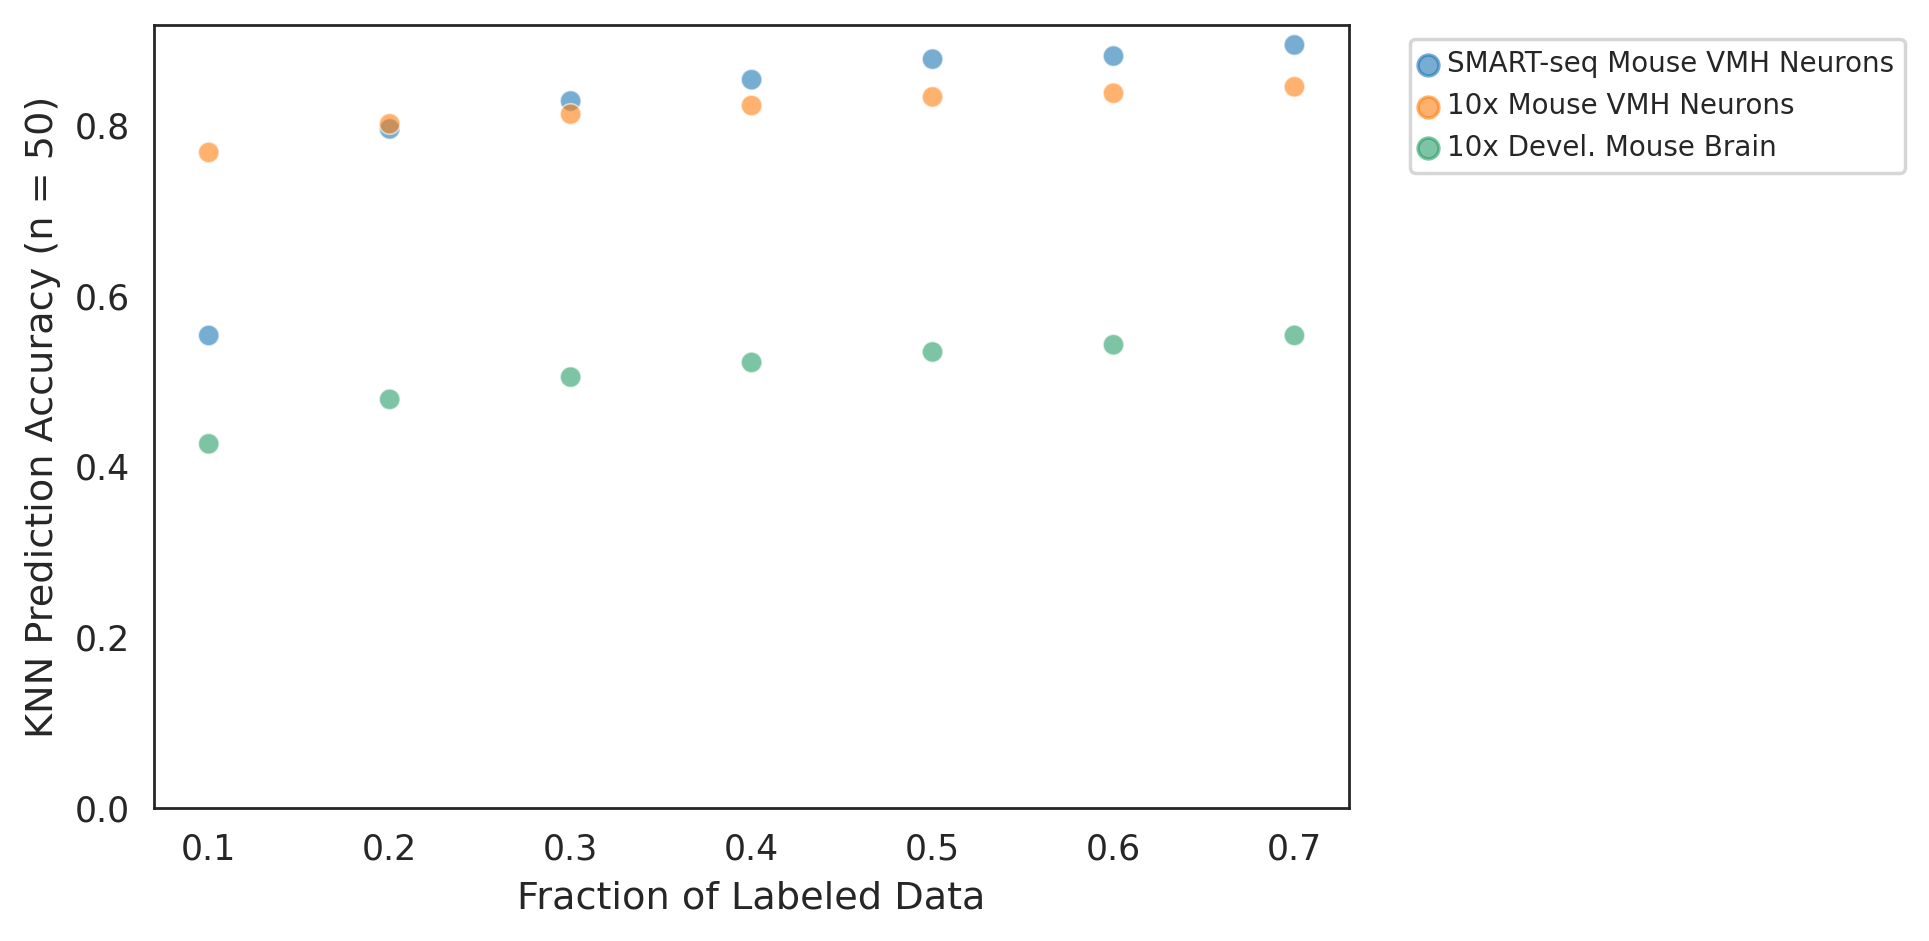

In [ ]:
#Maybe add number of cells below
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Percent', y='Accuracy', data=allPreds, hue='Dataset')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Fraction of Labeled Data",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n = 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

### **Time per Epoch for MCML vs scVI**

In [ ]:
mcmlTimes = pd.read_csv(data_path+'/timeComparisonsMCML.csv')

mcmlTimes.head()

,Unnamed: 0,Time,Dataset,Embed,Cells
0,0,54.109435,pseudotime,LDVAE,1075
1,1,73.946568,pseudotime,SCANVI,1075
2,2,9.272540,pseudotime,Recon MCML 50D,1075
3,3,9.306313,pseudotime,Cell Type MCML 50D,1075
4,4,137.753447,smartseq,LDVAE,3850


In [ ]:
np.unique(mcmlTimes.Dataset)

array(['lamanno', 'pseudotime', 'smartseq', 'tenx'], dtype=object)

In [ ]:
mcmlTimes['Runtime'] = mcmlTimes['Time']

Divide times by number of epochs (so times are comparable across methods)

In [ ]:
#400 epochs - pseudotime, 400 epochs- smartseq, 192 epochs - tenx, 29 epochs - lamanno (scanvi and ldvae)
#100 epochs for all mcml

mcmlTimes['Time'][mcmlTimes['Embed'].isin(['Recon MCML 50D','Cell Type MCML 50D'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['Recon MCML 50D','Cell Type MCML 50D'])]/100
mcmlTimes.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,Time,Dataset,Embed,Cells,Runtime
0,0,54.109435,pseudotime,LDVAE,1075,54.109435
1,1,73.946568,pseudotime,SCANVI,1075,73.946568
2,2,0.092725,pseudotime,Recon MCML 50D,1075,9.272540
3,3,0.093063,pseudotime,Cell Type MCML 50D,1075,9.306313
4,4,137.753447,smartseq,LDVAE,3850,137.753447


In [ ]:
mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['pseudotime','smartseq'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['pseudotime','smartseq'])]/400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['tenx'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['tenx'])]/192

mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['lamanno'])] = mcmlTimes['Time'][mcmlTimes['Embed'].isin(['SCANVI','LDVAE']) & mcmlTimes['Dataset'].isin(['lamanno'])]/29
mcmlTimes.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Time,Dataset,Embed,Cells,Runtime
0,0,0.135274,pseudotime,LDVAE,1075,54.109435
1,1,0.184866,pseudotime,SCANVI,1075,73.946568
2,2,0.092725,pseudotime,Recon MCML 50D,1075,9.272540
3,3,0.093063,pseudotime,Cell Type MCML 50D,1075,9.306313
4,4,0.344384,smartseq,LDVAE,3850,137.753447


In [ ]:
mcmlTimes['Dataset'] = [i.replace('smartseq','SMART-seq Mouse VMH Neurons\n(3,850 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('tenx','10x Mouse VMH Neurons\n(41,580 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('pseudotime','$\it{C. elegans}$ Devel. Neurons\n(1,075 cells)') for i in mcmlTimes['Dataset']] 
mcmlTimes['Dataset'] = [i.replace('lamanno','10x Devel. Mouse Brain\n(292,495 cells)') for i in mcmlTimes['Dataset']] 


In [ ]:
axisFontSize = 11-2
tickFontSize = 10-2
figsize =(10,4)
dodge=0.4
fname = None
ymin = 0

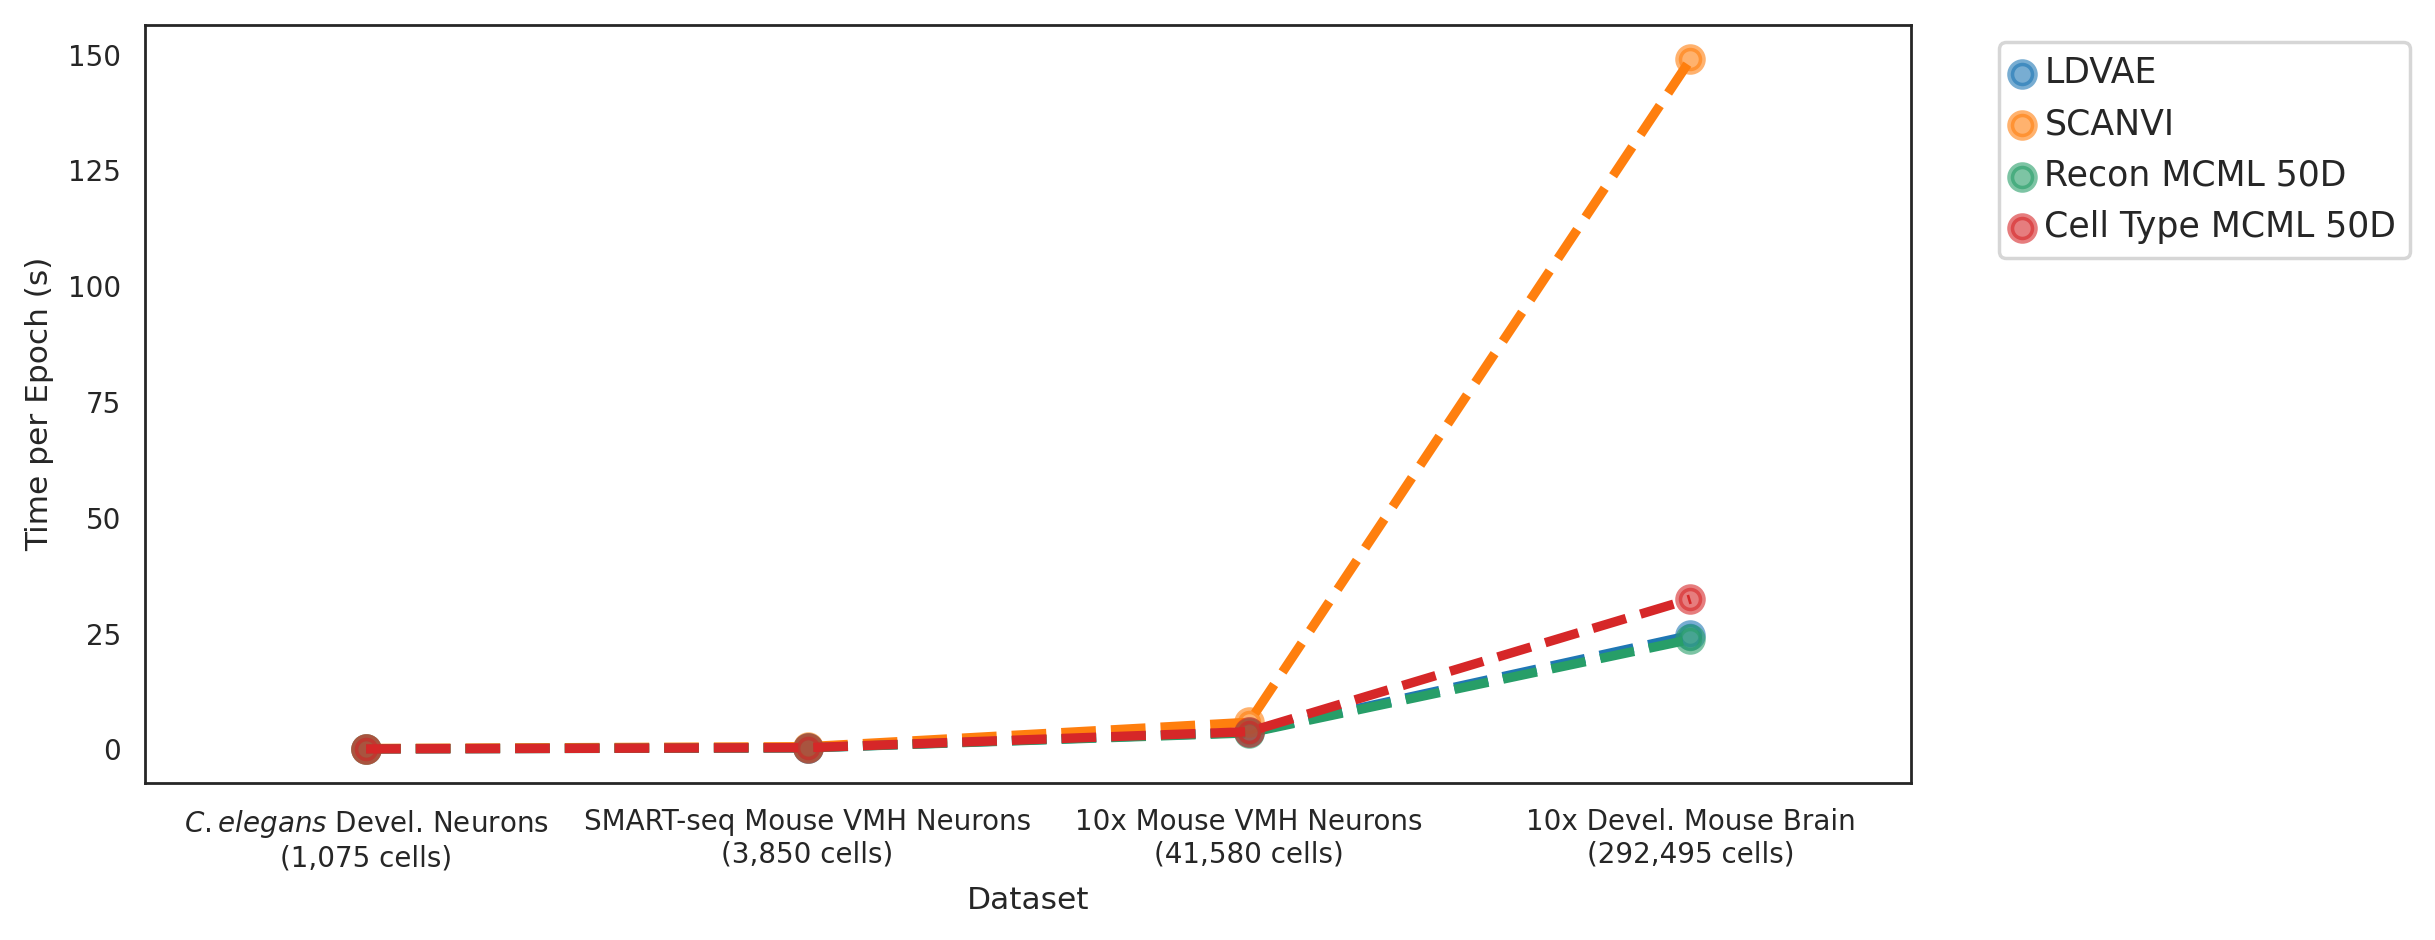

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Time', data=mcmlTimes, hue='Embed',linestyles="--")
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})


plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Time per Epoch (s)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


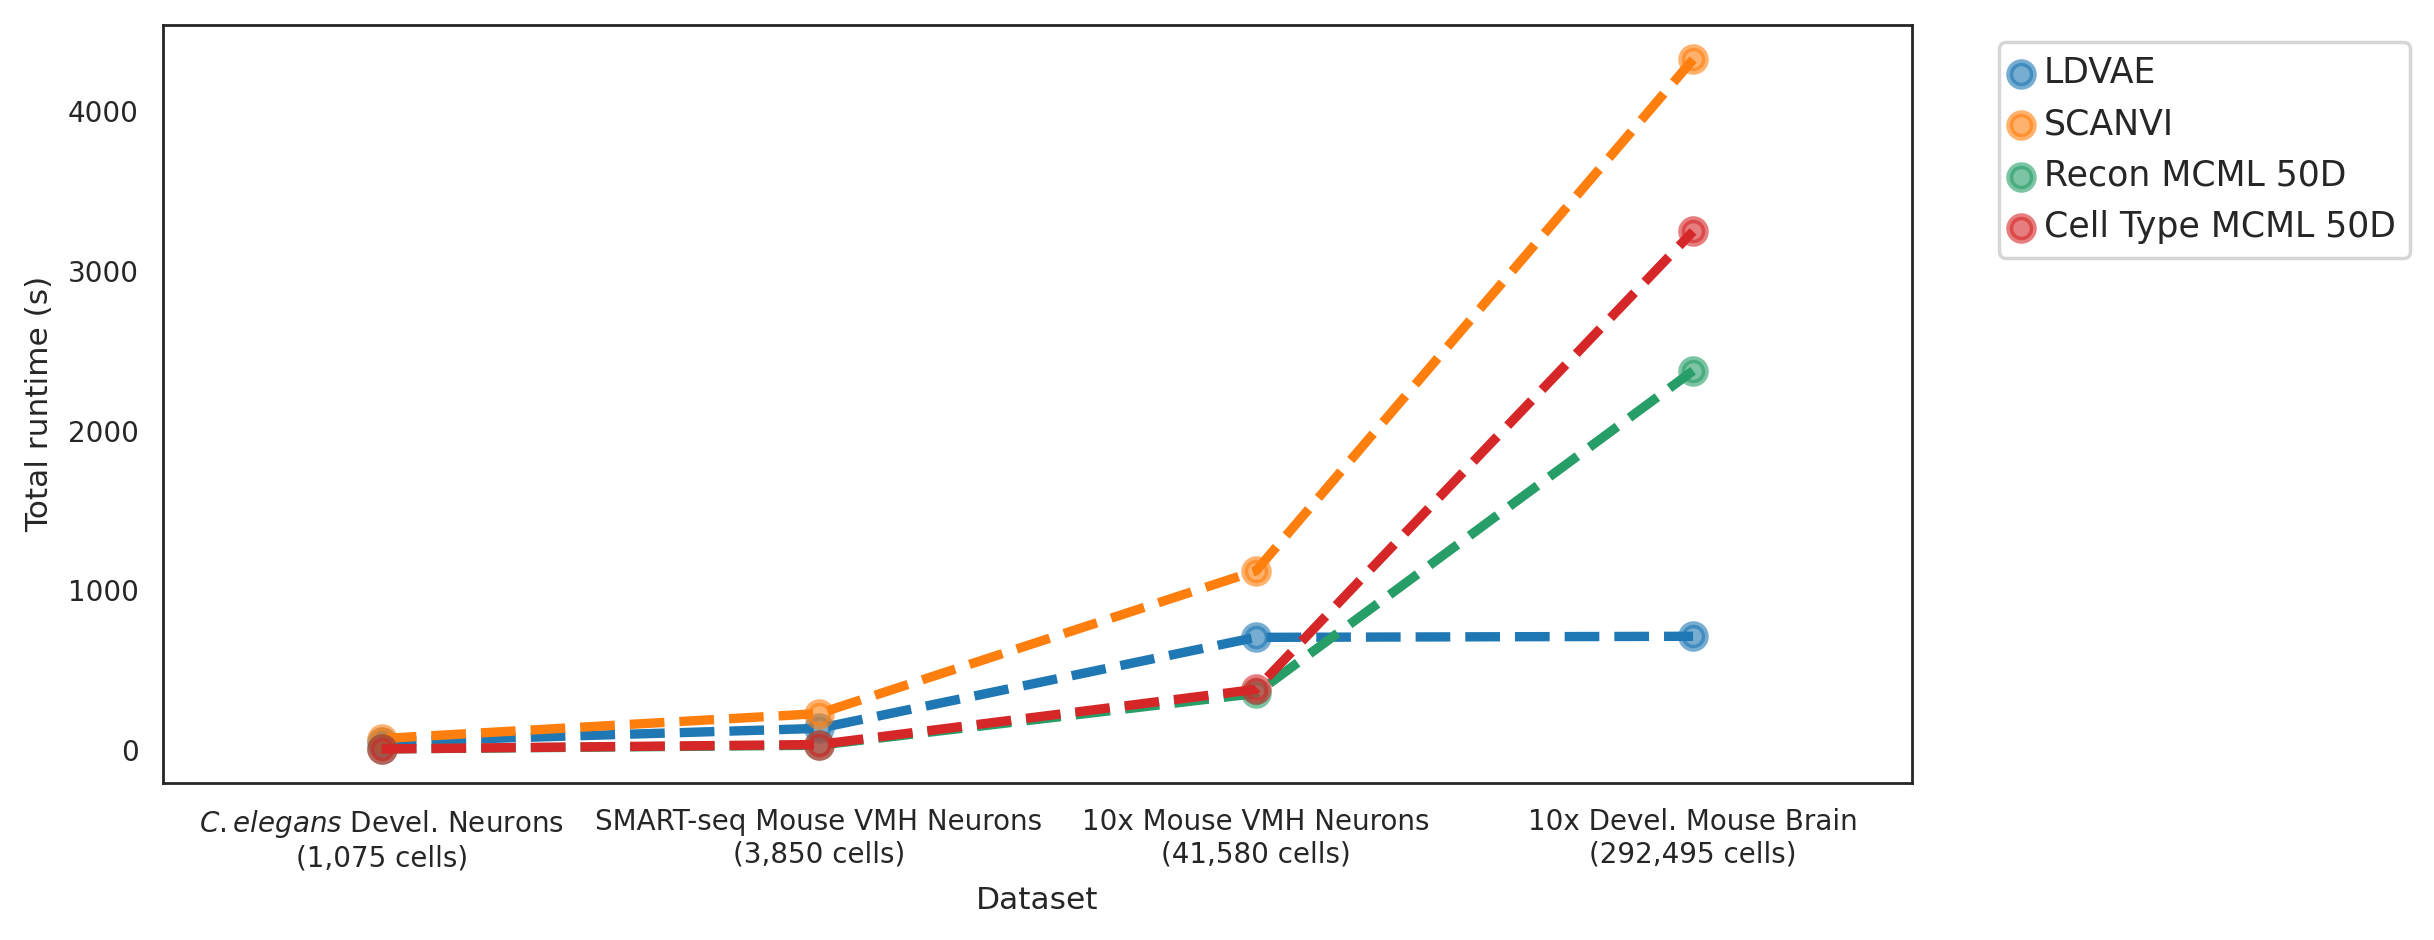

In [ ]:
plt.figure(figsize=figsize)
g=sns.pointplot(x='Dataset', y='Runtime', data=mcmlTimes, hue='Embed',linestyles="--")
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})


plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Total runtime (s)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


### **MCML with 100% NCA loss vs sklearn NCA**

In [ ]:
ncaLosses = pd.read_csv(data_path+'/sklearnNCAComps.csv')

ncaLosses.head()

,Unnamed: 0,Loss,Method,Time,Dataset
0,0,0.955284,MCML 50D,562.707319,10x VMH
1,1,0.453261,NCA 50D,3623.649164,10x VMH
2,2,0.956880,MCML 50D,556.053990,10x VMH
3,3,0.455265,NCA 50D,3615.831476,10x VMH
4,4,0.958116,MCML 50D,543.680363,10x VMH


In [ ]:
ncaLosses['Dataset'] = [i.replace('MERFISH','MERFISH MOp\n(6,963 cells)') for i in ncaLosses['Dataset']] 
ncaLosses['Dataset'] = [i.replace('10x VMH','10x Mouse VMH Neurons\n(41,580 cells)') for i in ncaLosses['Dataset']] 


In [ ]:
axisFontSize = 11-2
tickFontSize = 10-2
figsize =(5,3)
dodge=0.4
fname = None
ymin = 0

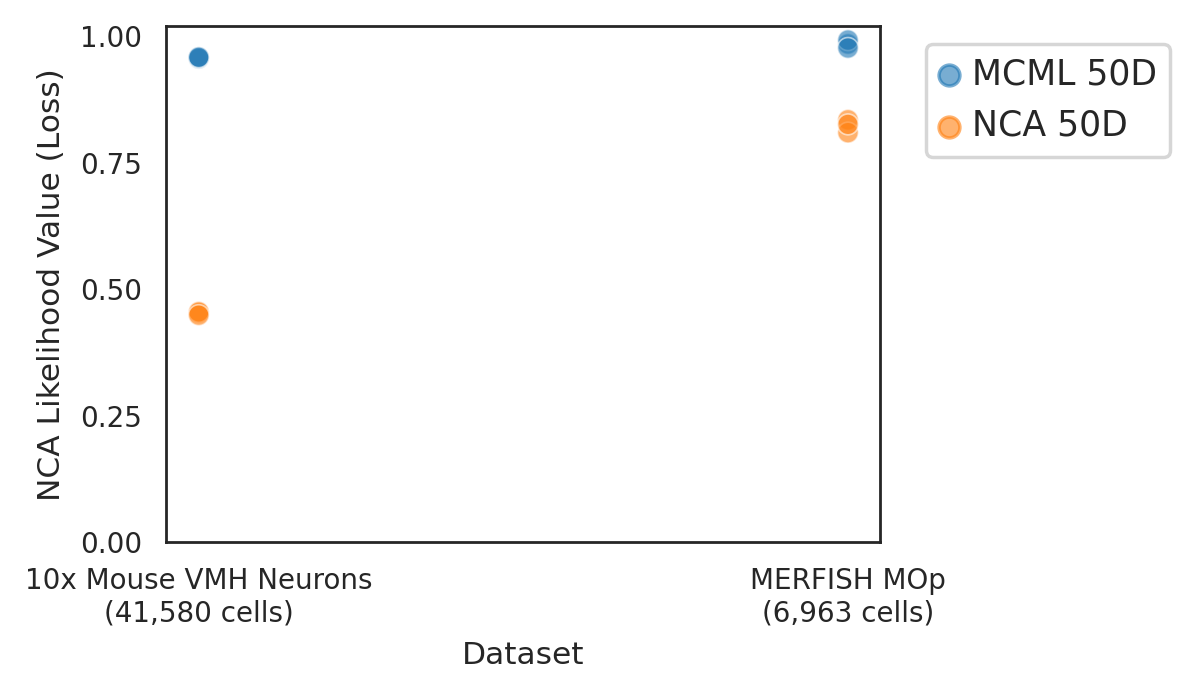

In [ ]:
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Dataset', y='Loss', data=ncaLosses, hue='Method')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.ylim(ymin=ymin)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("NCA Likelihood Value (Loss)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


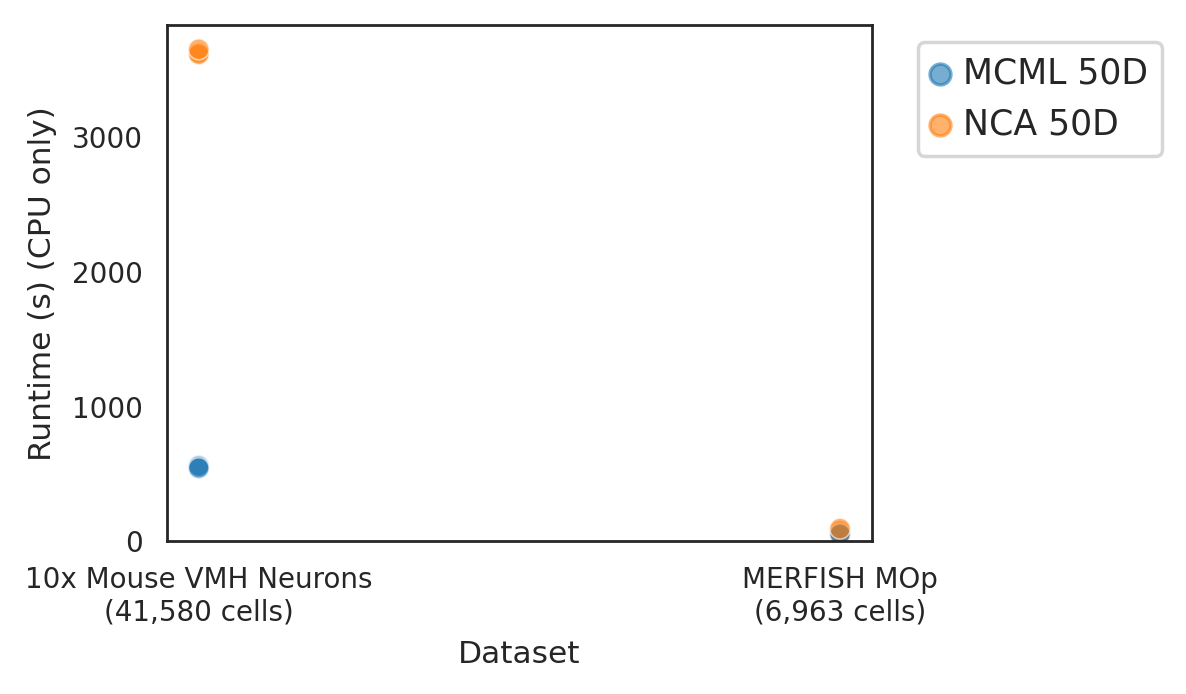

In [ ]:
plt.figure(figsize=figsize)
g=sns.scatterplot(x='Dataset', y='Time', data=ncaLosses, hue='Method')
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.ylim(ymin=ymin)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("Runtime (s) (CPU only)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()

if(fname != None):
  plt.savefig(fname)
else:
  plt.show()


### **Distortion Plots in High and Low Dimensions**
Coupled and non-coupled PCA/t-SNE/UMAP

#### **Equidistant Distortion Metrics**

In [ ]:
def printInfo(res):
  all = np.unique(res.Embed)
  sub = res[res['Embed'].isin(['Integrated-Scaled Ambient'])]
  ambVars = [sub['Vars'],sub['Ratio'],sub['RatioKNN']]
  for i in all:
    #Max var / ambient var
    calc = res[res['Embed'].isin([i])]
    max = np.max(calc['Vars'])/ambVars[0]
    print(i+' var max: '+str(max))
    #Min var / ambient var
    min = np.min(calc['Vars'])/ambVars[0]
    print(i+' var min: '+str(min))


    #Max ratio / ambient ratio
    calc = res[res['Embed'].isin([i])]
    max = np.max(calc['Ratio'])/ambVars[1]
    print(i+' ratio max: '+str(max))
    #Min ratio / ambient ratio
    min = np.min(calc['Ratio'])/ambVars[1]
    print(i+' ratio min: '+str(min))


    #Max ratio / ambient ratio
    calc = res[res['Embed'].isin([i])]
    max = np.max(calc['RatioKNN'])/ambVars[2]
    print(i+' ratio knn max: '+str(max))
    #Min ratio / ambient ratio
    min = np.min(calc['RatioKNN'])/ambVars[2]
    print(i+' ratio knn min: '+str(min))
      

In [ ]:
tenxEq = pd.read_csv(data_path+'/distort10x.csv')
tenxEq.head()

,Unnamed: 0,Vars,Embed,LogVars,Ratio,RatioKNN
0,0,0.520093,PCA 15D,-0.653747,3.052037,2.347171
1,1,6.896855,PCA 15D t-SNE,1.931066,168.707474,58.069157
2,2,1.194494,PCA 15D UMAP,0.177722,64.328323,24.159710
3,3,0.490751,PCA 50D,-0.711819,2.210660,1.758959
4,4,7.283585,PCA 50D t-SNE,1.985623,267.815613,50.184299


In [ ]:
printInfo(tenxEq)

Integrated-Scaled Ambient var max: 36    1.0
Name: Vars, dtype: float64
Integrated-Scaled Ambient var min: 36    1.0
Name: Vars, dtype: float64
Integrated-Scaled Ambient ratio max: 36    1.0
Name: Ratio, dtype: float64
Integrated-Scaled Ambient ratio min: 36    1.0
Name: Ratio, dtype: float64
Integrated-Scaled Ambient ratio knn max: 36    1.0
Name: RatioKNN, dtype: float64
Integrated-Scaled Ambient ratio knn min: 36    1.0
Name: RatioKNN, dtype: float64
PCA 100D var max: 36    53.010008
Name: Vars, dtype: float64
PCA 100D var min: 36    47.373412
Name: Vars, dtype: float64
PCA 100D ratio max: 36    2.106364
Name: Ratio, dtype: float64
PCA 100D ratio min: 36    2.062468
Name: Ratio, dtype: float64
PCA 100D ratio knn max: 36    1.432634
Name: RatioKNN, dtype: float64
PCA 100D ratio knn min: 36    1.395028
Name: RatioKNN, dtype: float64
PCA 100D UMAP var max: 36    95.808806
Name: Vars, dtype: float64
PCA 100D UMAP var min: 36    36.290619
Name: Vars, dtype: float64
PCA 100D UMAP ratio ma

In [ ]:
tenxEq['Embed'] = [i.replace('Integrated-Scaled Ambient','Ambient') for i in tenxEq['Embed']]

Utero E10.5 data

In [ ]:
uteroEq = pd.read_csv(data_path+'/distortUtE105.csv')
uteroEq.head()

,Unnamed: 0,Vars,Embed,LogVars,Ratio,RatioKNN
0,0,0.925687,PCA 15D,-0.077220,4.548433,2.829278
1,1,10.702757,PCA 15D t-SNE,2.370501,34.443367,24.944498
2,2,0.564349,PCA 15D UMAP,-0.572082,23.493973,20.979410
3,3,0.644038,PCA 50D,-0.439997,2.512758,2.560746
4,4,2.847382,PCA 50D t-SNE,1.046400,17.828094,23.102537


In [ ]:
printInfo(uteroEq)

Integrated-Scaled Ambient var max: 36    1.0
Name: Vars, dtype: float64
Integrated-Scaled Ambient var min: 36    1.0
Name: Vars, dtype: float64
Integrated-Scaled Ambient ratio max: 36    1.0
Name: Ratio, dtype: float64
Integrated-Scaled Ambient ratio min: 36    1.0
Name: Ratio, dtype: float64
Integrated-Scaled Ambient ratio knn max: 36    1.0
Name: RatioKNN, dtype: float64
Integrated-Scaled Ambient ratio knn min: 36    1.0
Name: RatioKNN, dtype: float64
PCA 100D var max: 36    128.696118
Name: Vars, dtype: float64
PCA 100D var min: 36    126.713819
Name: Vars, dtype: float64
PCA 100D ratio max: 36    1.860791
Name: Ratio, dtype: float64
PCA 100D ratio min: 36    1.849065
Name: Ratio, dtype: float64
PCA 100D ratio knn max: 36    0.856094
Name: RatioKNN, dtype: float64
PCA 100D ratio knn min: 36    0.849575
Name: RatioKNN, dtype: float64
PCA 100D UMAP var max: 36    469.98487
Name: Vars, dtype: float64
PCA 100D UMAP var min: 36    161.091842
Name: Vars, dtype: float64
PCA 100D UMAP ratio

In [ ]:
uteroEq['Embed'] = [i.replace('Integrated-Scaled Ambient','Ambient') for i in uteroEq['Embed']]

In [ ]:
def plotLatentDistorts(ax,allVals, x ,y,hue, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10, errwidth=1, figsize =(8,4), dodge=0.4, fname = None, ymin = 0):
  """ Plot equidstant distortion plots """

  #plt.figure(figsize=figsize)
  g=sns.pointplot(x=x, y=y, data=allVals, hue=hue, err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge,ax=ax)
  plt.setp(g.collections, alpha=.6) #for the markers
  g.legend(prop={"size":8})

  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)


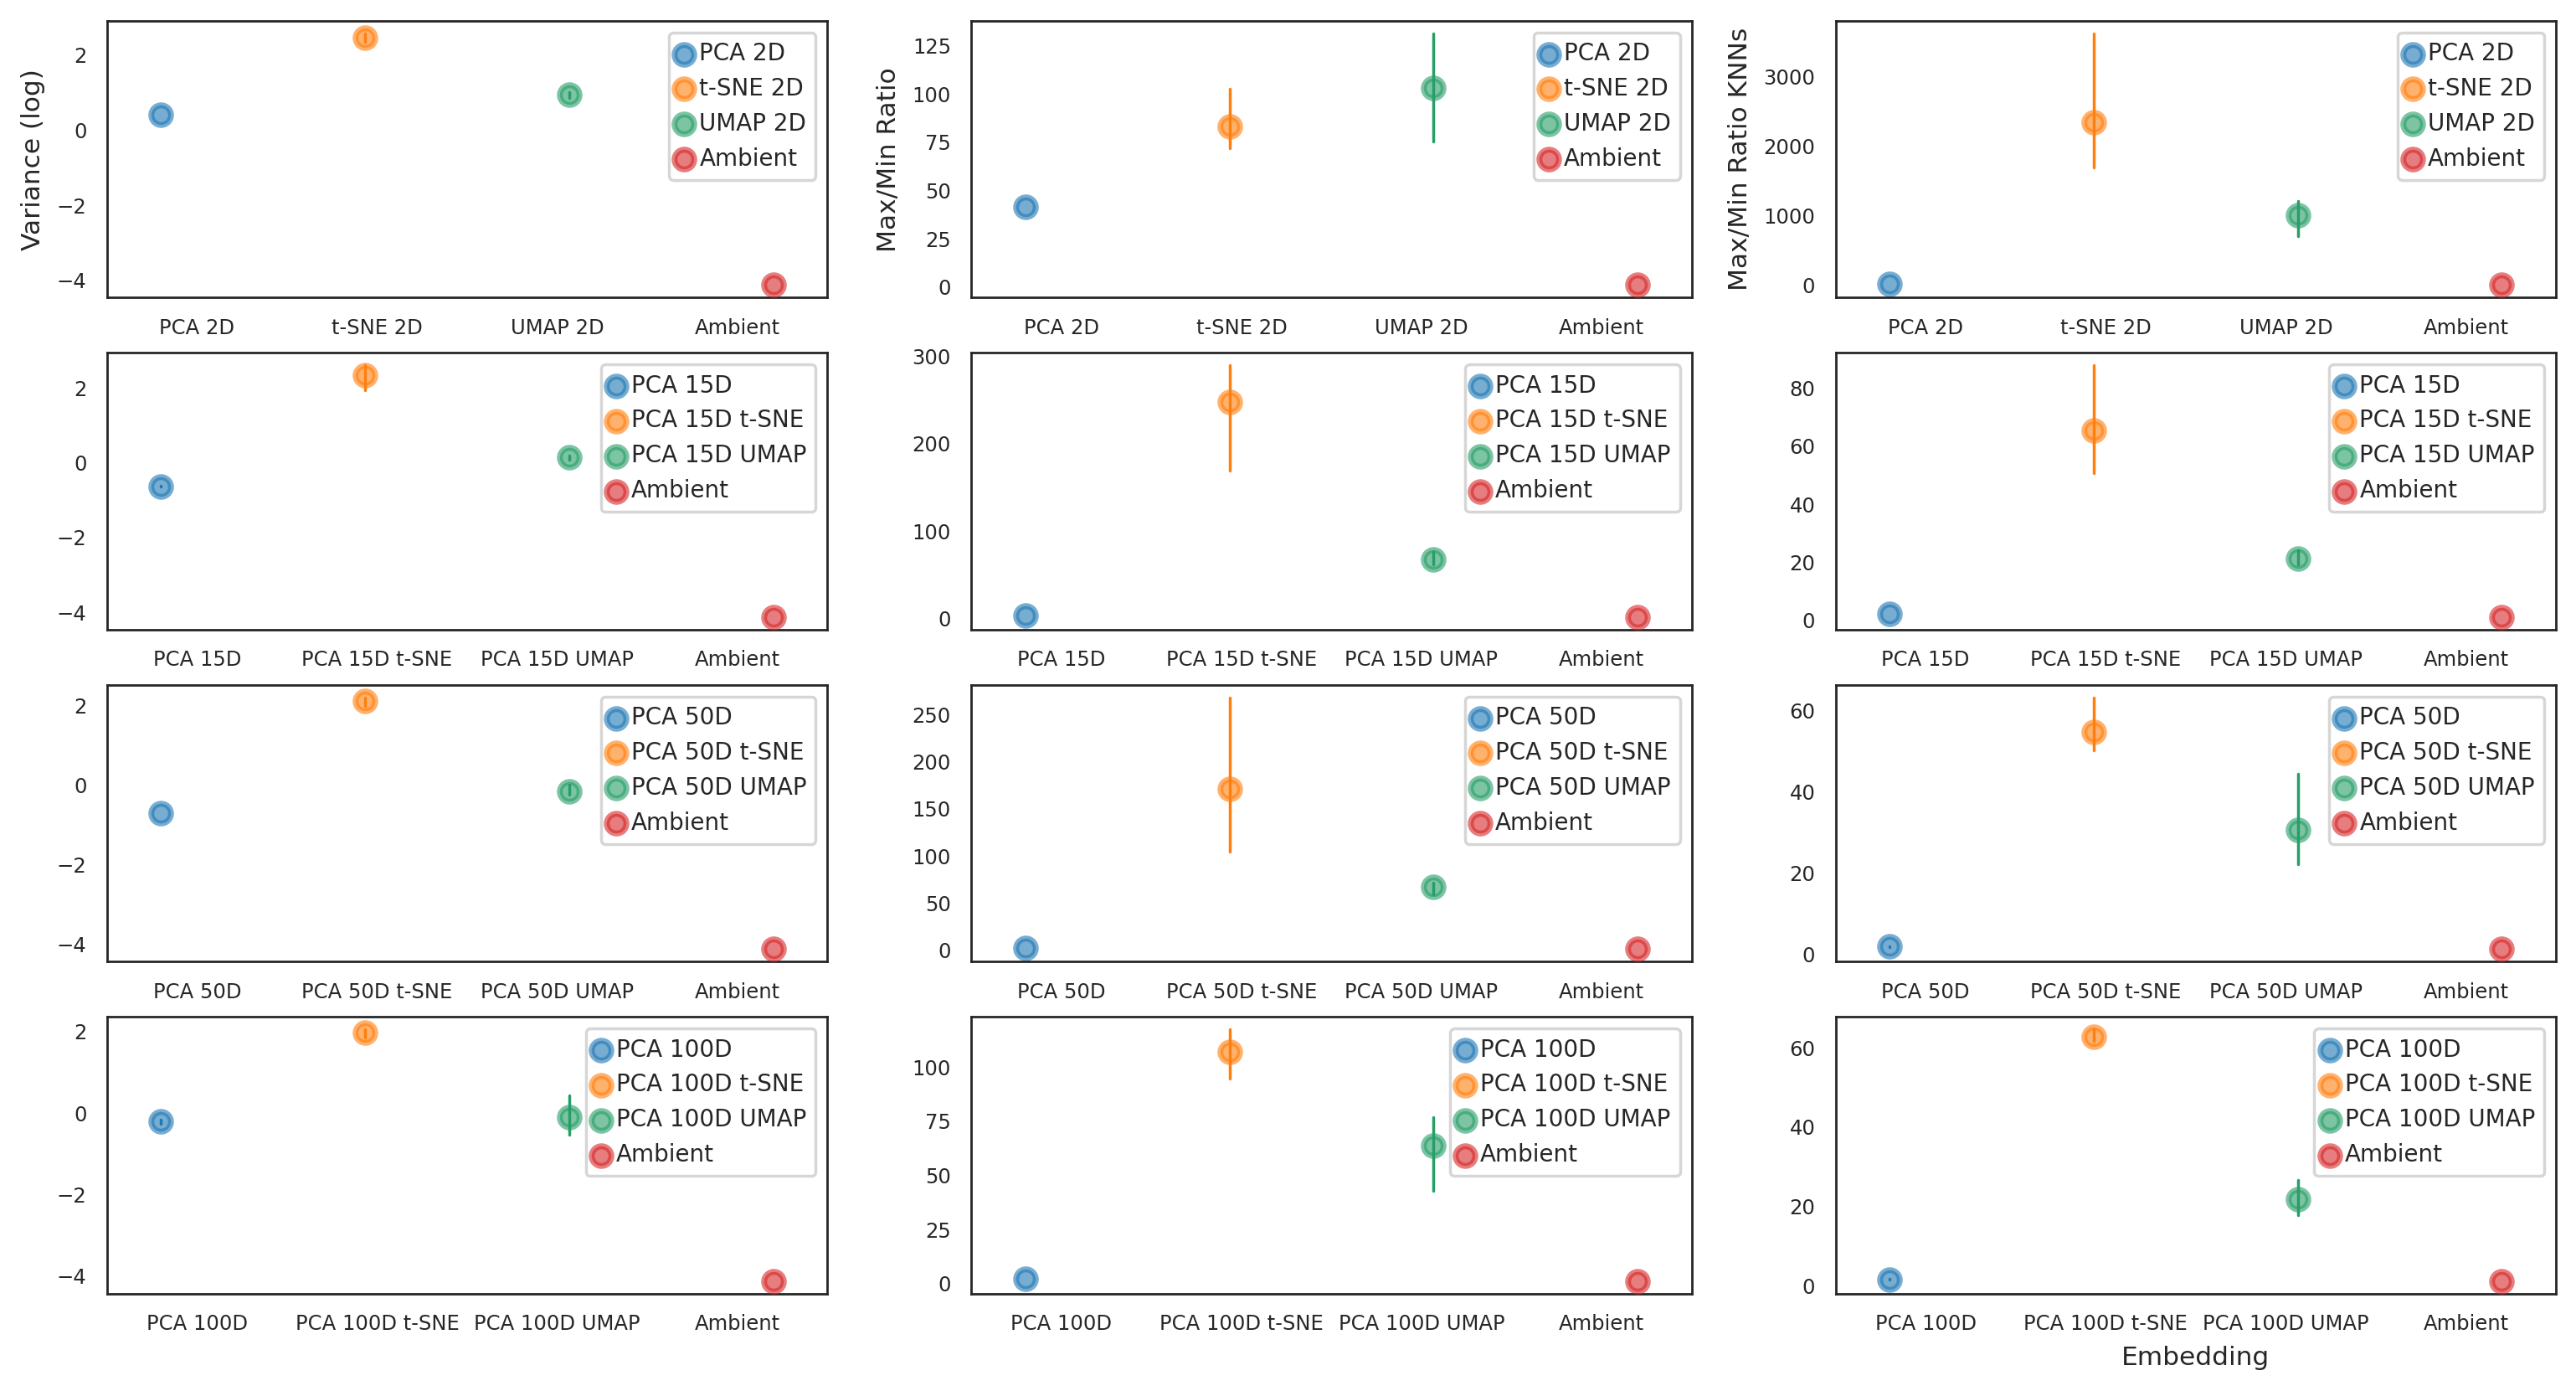

In [ ]:
#tenx plots

fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(15,8))
rows = ['LogVars','Ratio','RatioKNN']
rowNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
cols = ['2D','15D','50D','100D']

for i in range(len(rows)):

  for j in range(len(cols)):

    colInds = [cols[j] in i or 'Ambient' in i for i in tenxEq['Embed']]
    sub = tenxEq[colInds]


    if j == 0 :
      title = rowNames[i]
    else:
      title = ''

    if j == 3  and i == 2:
      xlab = 'Embedding'
    else:
      xlab = ''
    plotLatentDistorts(ax[j,i],sub,'Embed' ,rows[i],'Embed',xlab = xlab,ylab=title,axisFontSize = 9,tickFontSize = 7)




#plt.xticks(fontsize=5)
plt.show()

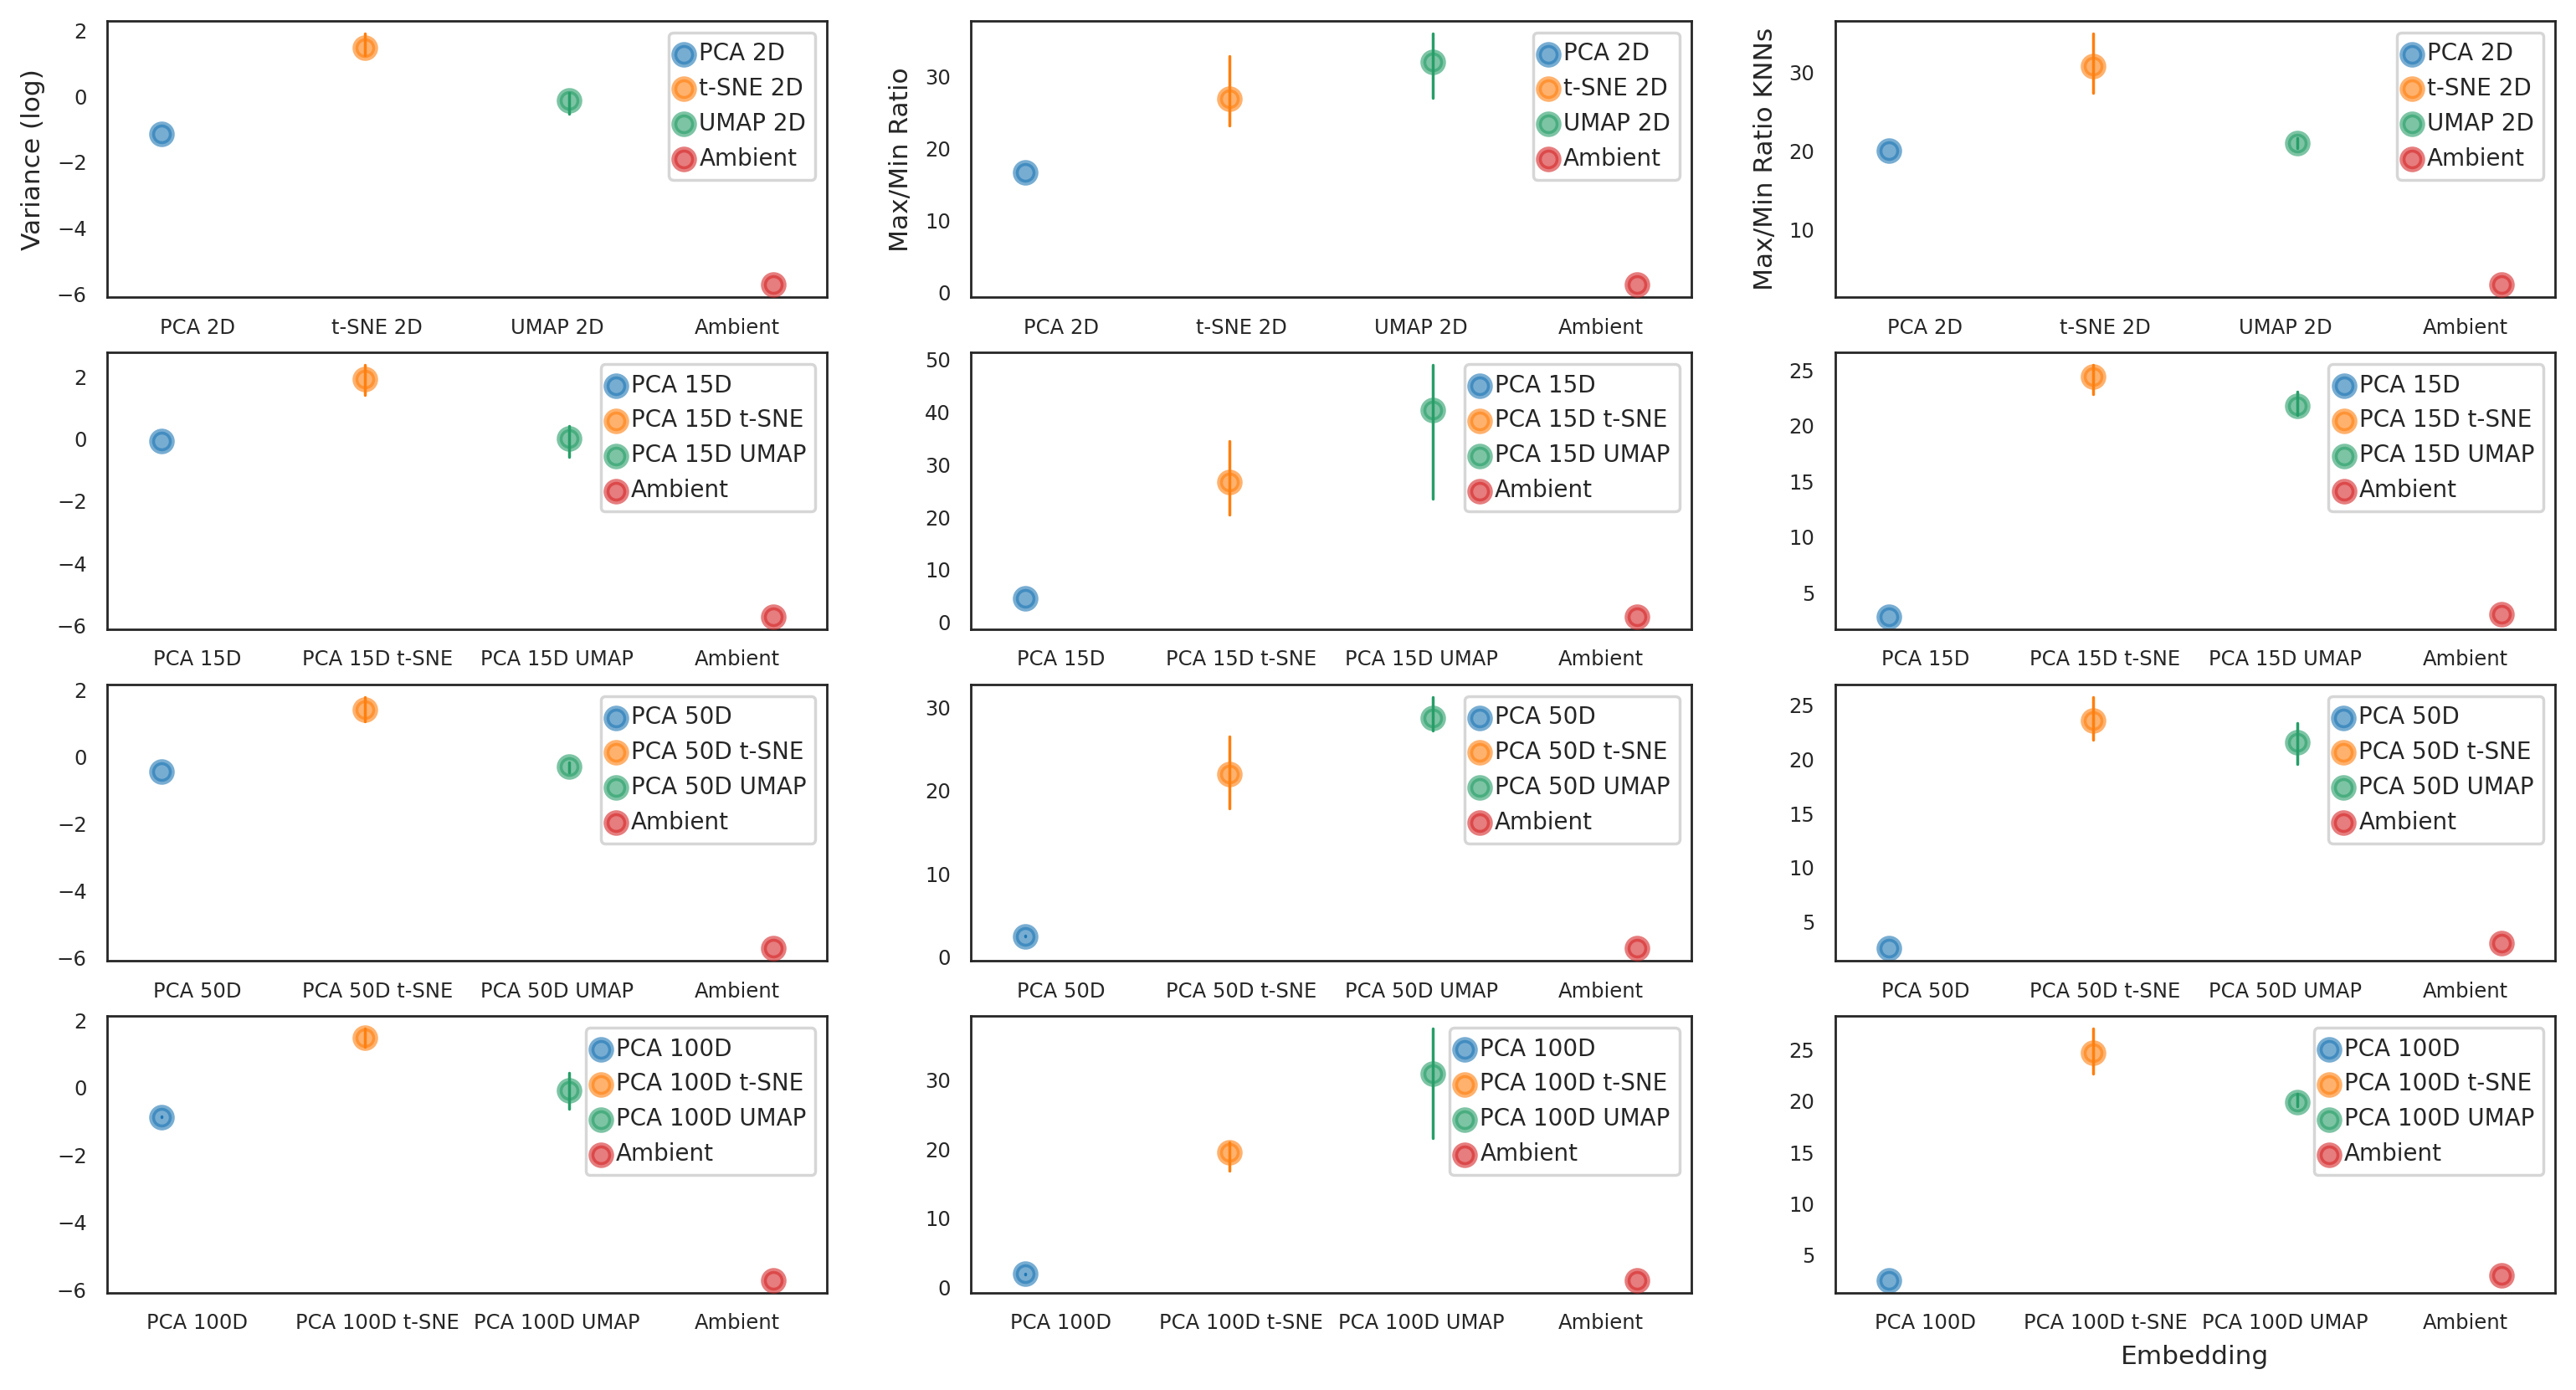

In [ ]:
#utero plots

fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(15,8))
rows = ['LogVars','Ratio','RatioKNN']
rowNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
cols = ['2D','15D','50D','100D']

for i in range(len(rows)):

  for j in range(len(cols)):

    colInds = [cols[j] in i or 'Ambient' in i for i in uteroEq['Embed']]
    sub = uteroEq[colInds]


    if j == 0 :
      title = rowNames[i]
    else:
      title = ''

    if j == 3  and i == 2:
      xlab = 'Embedding'
    else:
      xlab = ''
    plotLatentDistorts(ax[j,i],sub,'Embed' ,rows[i],'Embed',xlab = xlab,ylab=title,axisFontSize = 9,tickFontSize = 7)




#plt.xticks(fontsize=5)
plt.show()

#### **KNN Jaccard Distances for Latent Spaces**

For each datasets plot jaccard distance histograms for 30 NNs (with respect to ambient)

In [ ]:
exAmb = pd.read_csv(data_path+'/exAmb.csv')
exPCAAmb = pd.read_csv(data_path+'/exPCAAmb.csv')

merAmb = pd.read_csv(data_path+'/merAmb.csv')
merPCAAmb = pd.read_csv(data_path+'/merPCAAmb.csv')

tenxAmb = pd.read_csv(data_path+'/tenxAmb.csv')
tenxPCAAmb = pd.read_csv(data_path+'/tenxPCAAmb.csv')

smartAmb = pd.read_csv(data_path+'/smartAmb.csv')
smartPCAAmb = pd.read_csv(data_path+'/smartPCAAmb.csv')

tenxAmb.head()

,Unnamed: 0,x,latent
0,0,0.909091,PCA 15D
1,1,0.867925,PCA 15D
2,2,0.947368,PCA 15D
3,3,0.846154,PCA 15D
4,4,0.983051,PCA 15D


In [ ]:
np.unique(tenxAmb.latent)

array(['PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE', 'PCA 15D',
       'PCA 15D UMAP', 'PCA 15D t-SNE', 'PCA 2D', 'PCA 50D',
       'PCA 50D UMAP', 'PCA 50D t-SNE', 'UMAP 2D', 't-SNE 2D'],
      dtype=object)

In [ ]:
def plotHists(ax,allVals, x ,hue, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for jaccard distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  g=sns.ecdfplot(data=allVals, x=x, hue=hue,legend=True,ax=ax) #stat='probability', kde=True,edgecolor="white"
  g.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],prop={"size":9})

  g.set_xlim(xmin=0,xmax=1)

  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)


In [ ]:
#utero plots

def plotAmb(amb,ambPCA):
  fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(7,8))
  rows = ['2D','15D','50D','100D']
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(len(rows)):
    rowInds = [rows[i] in x for x in amb['latent']]
    sub = amb[rowInds]

    rowInds = [rows[i] in x for x in ambPCA['latent']]
    subPCA = ambPCA[rowInds]


    if i == 0:
      ylab = 'eCDF'
    else:
      ylab= ''

    if i == 3:
      xlab = 'Jaccard Distance (n=30 NNs)'
    else:
      xlab = ''
    
    plotHists(ax[i,0],sub,'x' ,'latent',ylab=ylab,axisFontSize = 9,tickFontSize = 8)
    if i != 0:
      plotHists(ax[i,1],subPCA,'x' ,'latent',xlab=xlab,axisFontSize = 9,tickFontSize = 8)
    else:
      plotHists(ax[i,1],sub,'x' ,'latent',axisFontSize = 9,tickFontSize = 8)




  #plt.xticks(fontsize=5)
  plt.show()

In [ ]:
def printAvgs(amb):
  '''Print avgs of all latent spaces for each dataset'''
  l = np.unique(amb.latent)
  d = {}
  for i in l:
    sub = amb[amb['latent'].isin([i])]
    avg = np.mean(sub['x'])
    d[i] = avg

  return d

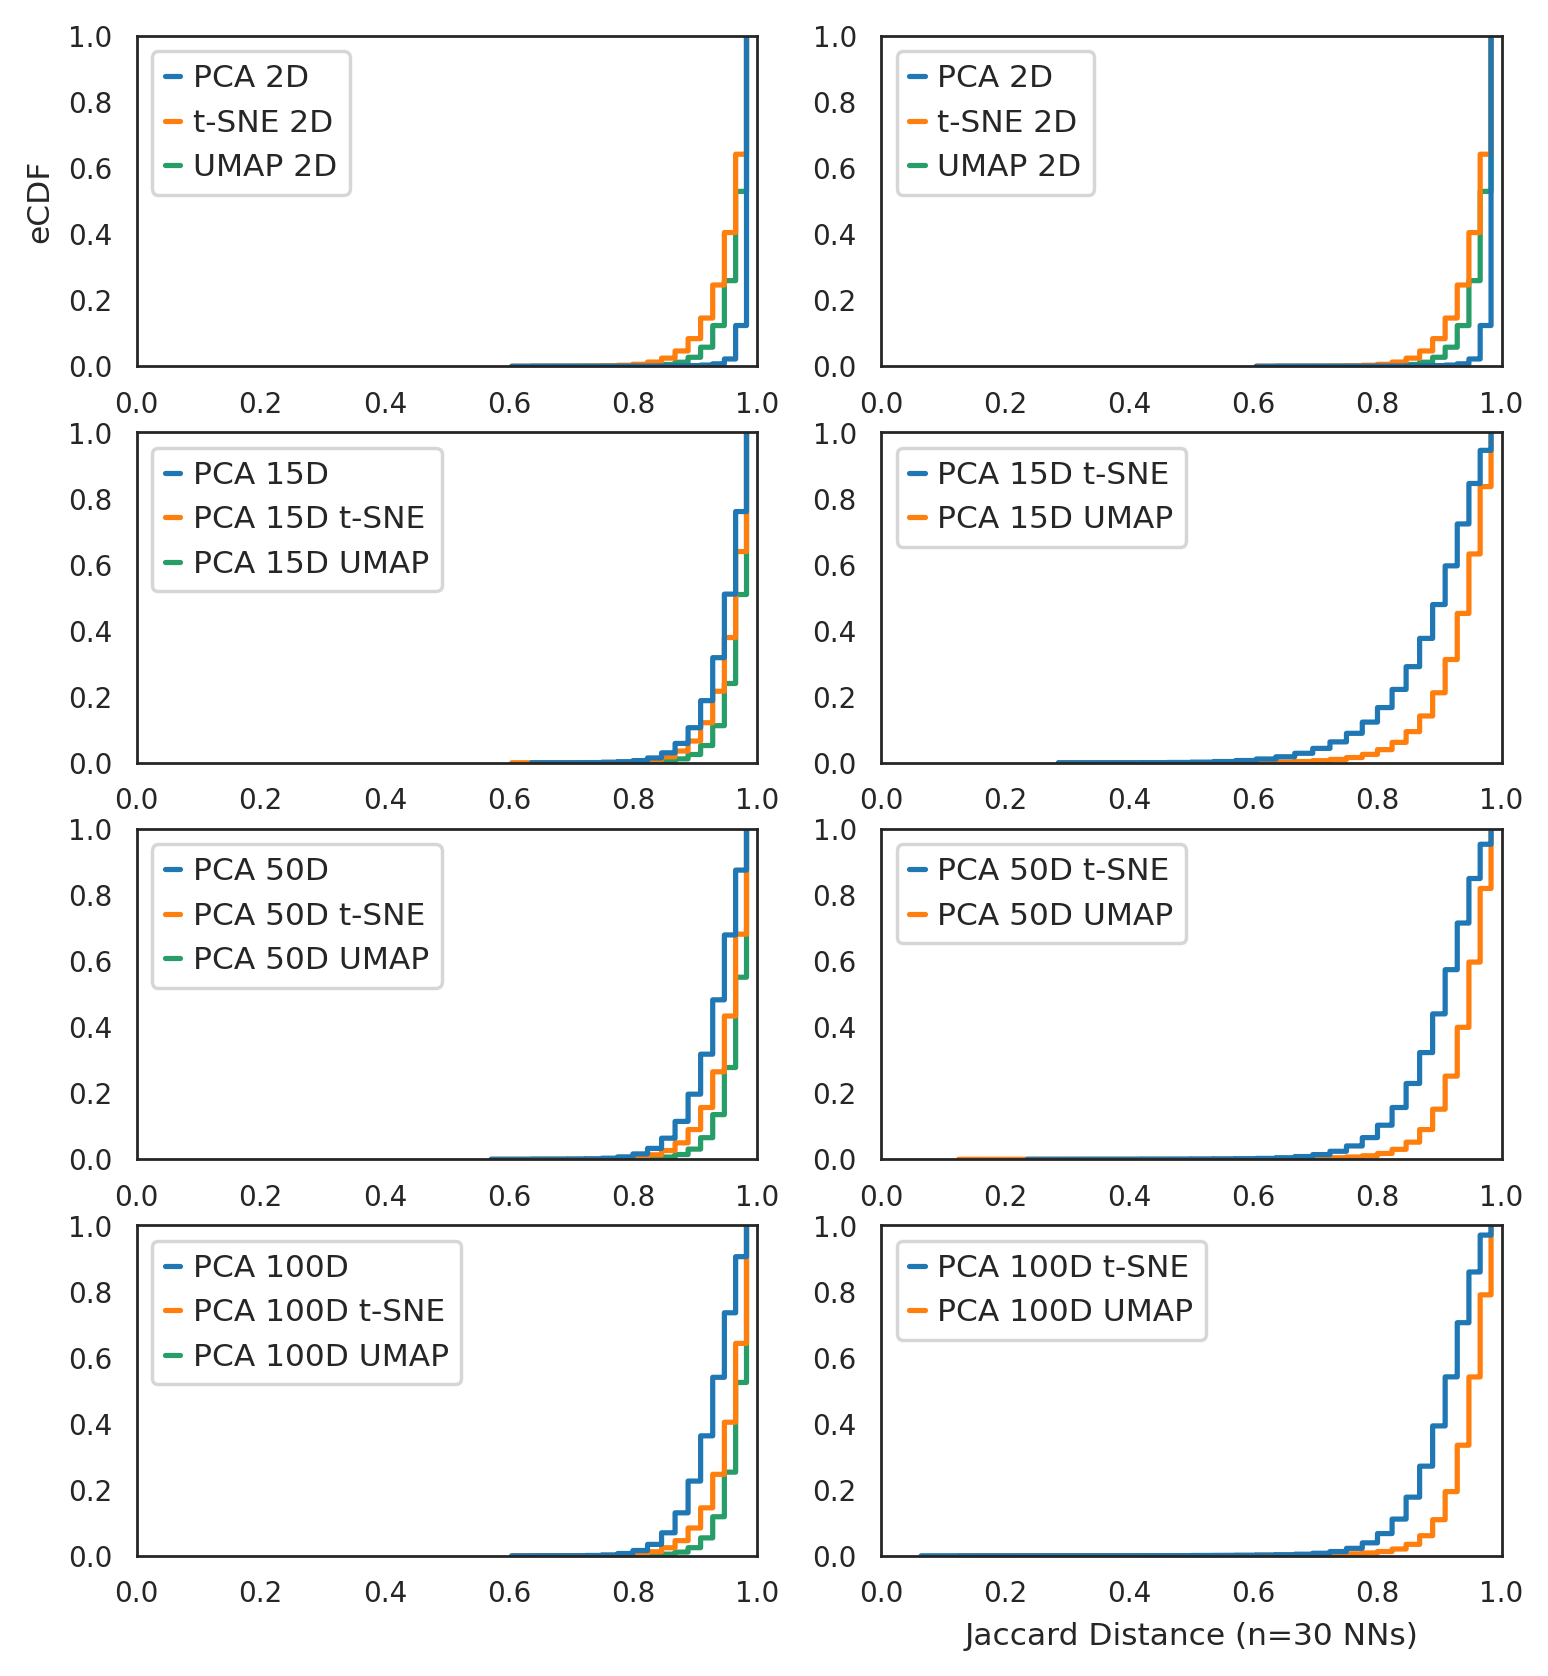

In [ ]:
#tenx data
plotAmb(tenxAmb,tenxPCAAmb)


In [ ]:
print(printAvgs(tenxAmb))
print(printAvgs(tenxPCAAmb))

{'PCA 100D': 0.9263511770208019, 'PCA 100D UMAP': 0.9650419307477938, 'PCA 100D t-SNE': 0.9532356570883572, 'PCA 15D': 0.9461652634863537, 'PCA 15D UMAP': 0.9656520871790255, 'PCA 15D t-SNE': 0.9556768218158441, 'PCA 2D': 0.9801586197346489, 'PCA 50D': 0.9308952265886912, 'PCA 50D UMAP': 0.9633310926900074, 'PCA 50D t-SNE': 0.9511600190995163, 'UMAP 2D': 0.9646146730262796, 't-SNE 2D': 0.9532483557675093}


{'PCA 100D UMAP': 0.9433650605650264,
 'PCA 100D t-SNE': 0.902394075429988,
 'PCA 15D UMAP': 0.9289745082178577,
 'PCA 15D t-SNE': 0.8826832793461341,
 'PCA 50D UMAP': 0.9373950438671322,
 'PCA 50D t-SNE': 0.8953476640332102}

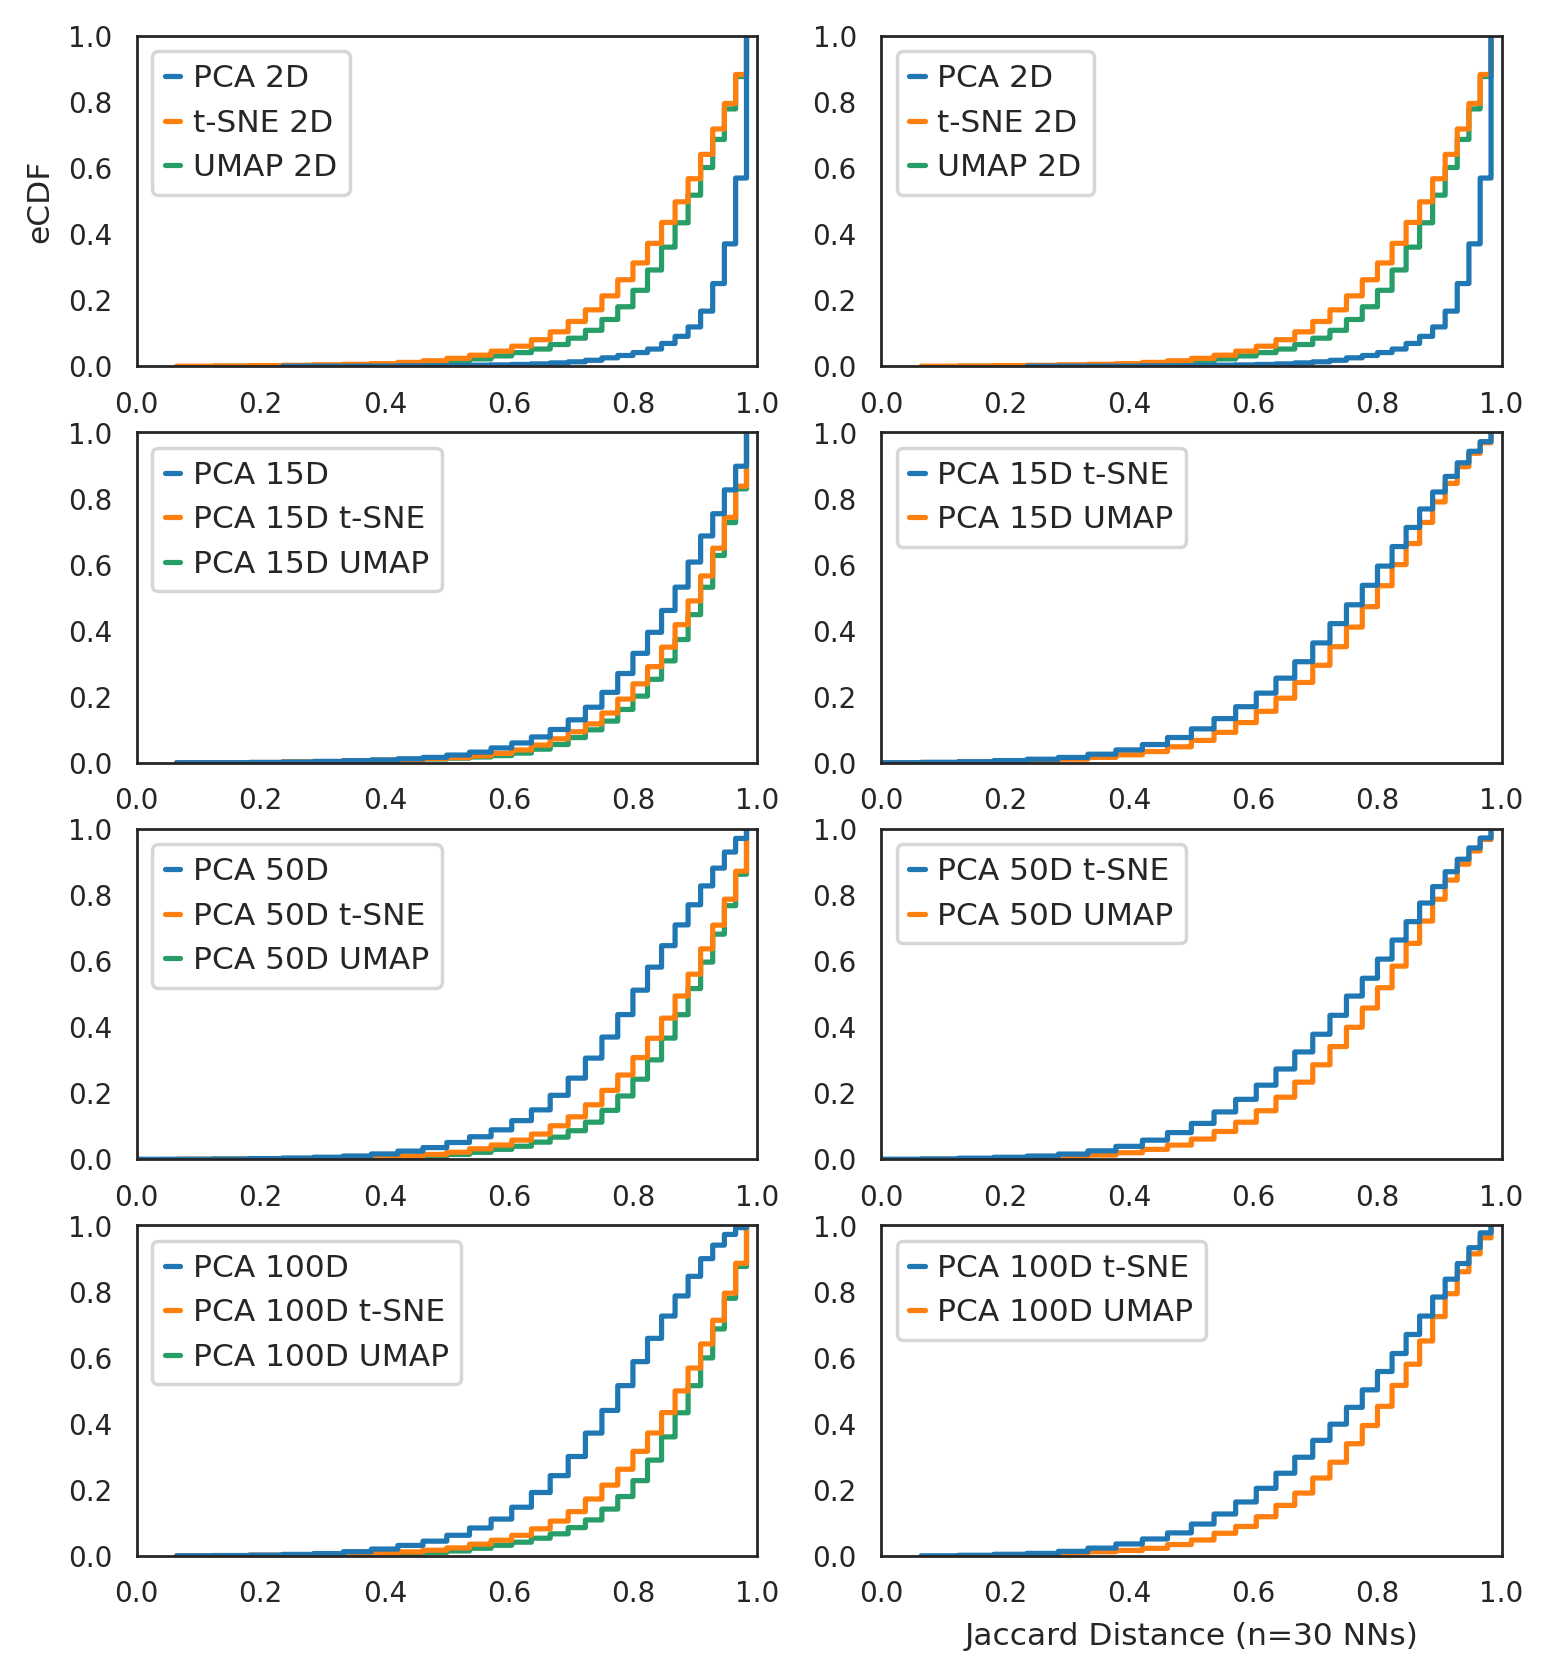

In [ ]:
#ex utero E8.5 data
plotAmb(exAmb,exPCAAmb)

In [ ]:
print(printAvgs(exAmb))
print(printAvgs(exPCAAmb))

{'PCA 100D': 0.761142110135855, 'PCA 100D UMAP': 0.8679239173446025, 'PCA 100D t-SNE': 0.8464615382879859, 'PCA 15D': 0.8417286359158213, 'PCA 15D UMAP': 0.8799134111000806, 'PCA 15D t-SNE': 0.8698326687946615, 'PCA 2D': 0.9470200829707064, 'PCA 50D': 0.7864324947489758, 'PCA 50D UMAP': 0.8671790438070608, 'PCA 50D t-SNE': 0.8493378989486555, 'UMAP 2D': 0.8678109485168292, 't-SNE 2D': 0.8467203768491429}
{'PCA 100D UMAP': 0.7971241618263106, 'PCA 100D t-SNE': 0.7547226868564937, 'PCA 15D UMAP': 0.770424330159429, 'PCA 15D t-SNE': 0.7440923685525767, 'PCA 50D UMAP': 0.7755672884252244, 'PCA 50D t-SNE': 0.738974796996989}


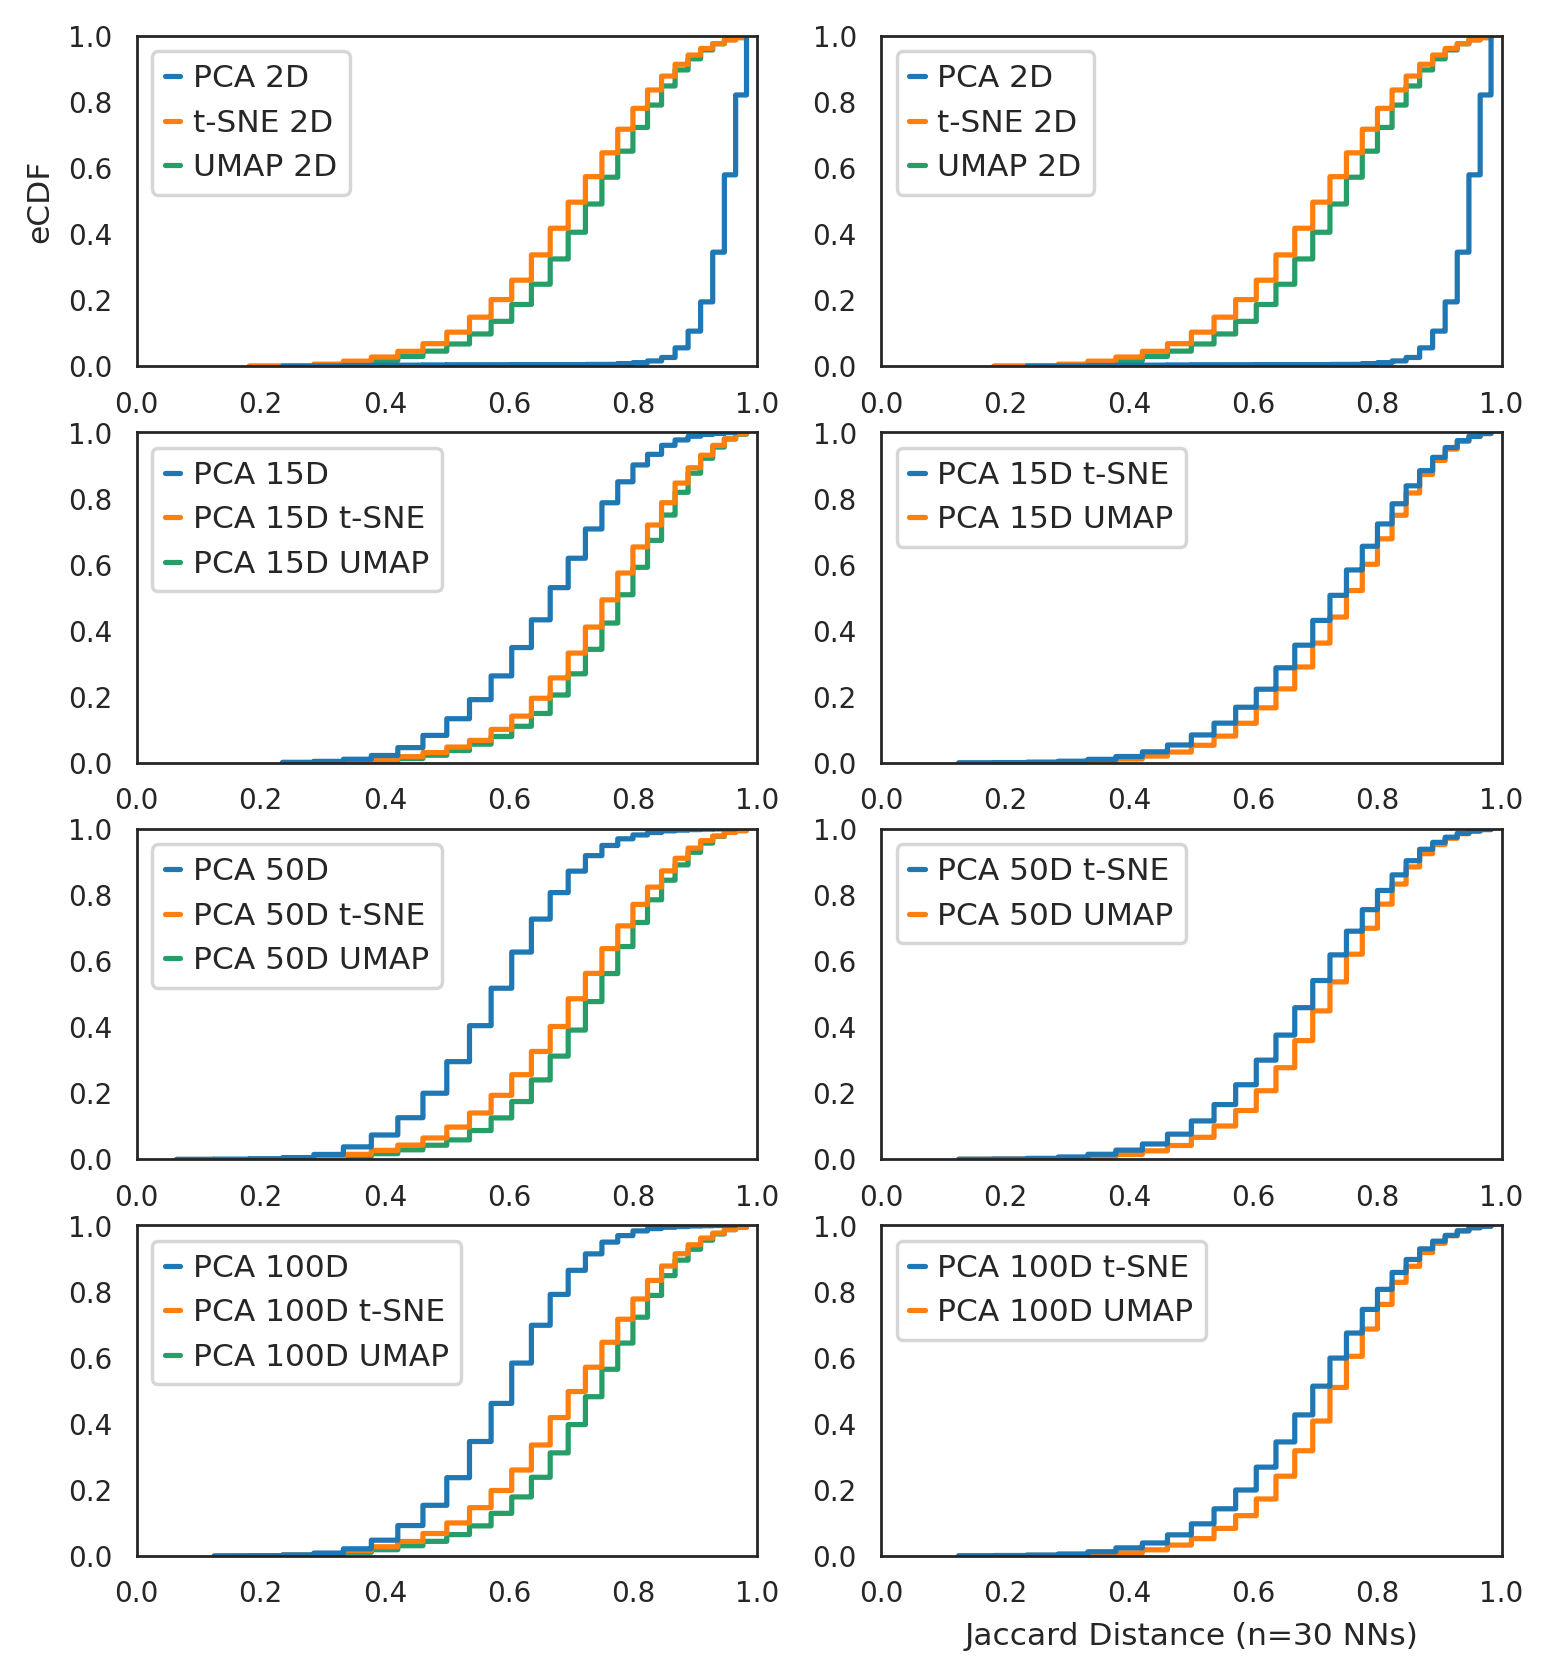

In [ ]:
#smartseq data
plotAmb(smartAmb,smartPCAAmb)

In [ ]:
print(printAvgs(smartAmb))
print(printAvgs(smartPCAAmb))

{'PCA 100D': 0.5929367998004084, 'PCA 100D UMAP': 0.7298735712398234, 'PCA 100D t-SNE': 0.7007668694831052, 'PCA 15D': 0.6622100850444703, 'PCA 15D UMAP': 0.7700340393660681, 'PCA 15D t-SNE': 0.7523485730377257, 'PCA 2D': 0.9412209073735639, 'PCA 50D': 0.5782632106175883, 'PCA 50D UMAP': 0.7310704992242927, 'PCA 50D t-SNE': 0.7035615931731318, 'UMAP 2D': 0.727320169805289, 't-SNE 2D': 0.6999788351079331}
{'PCA 100D UMAP': 0.7255422976217395, 'PCA 100D t-SNE': 0.6954630816929293, 'PCA 15D UMAP': 0.7415082603285714, 'PCA 15D t-SNE': 0.7202359031292279, 'PCA 50D UMAP': 0.7152662111601585, 'PCA 50D t-SNE': 0.6861752614571319}


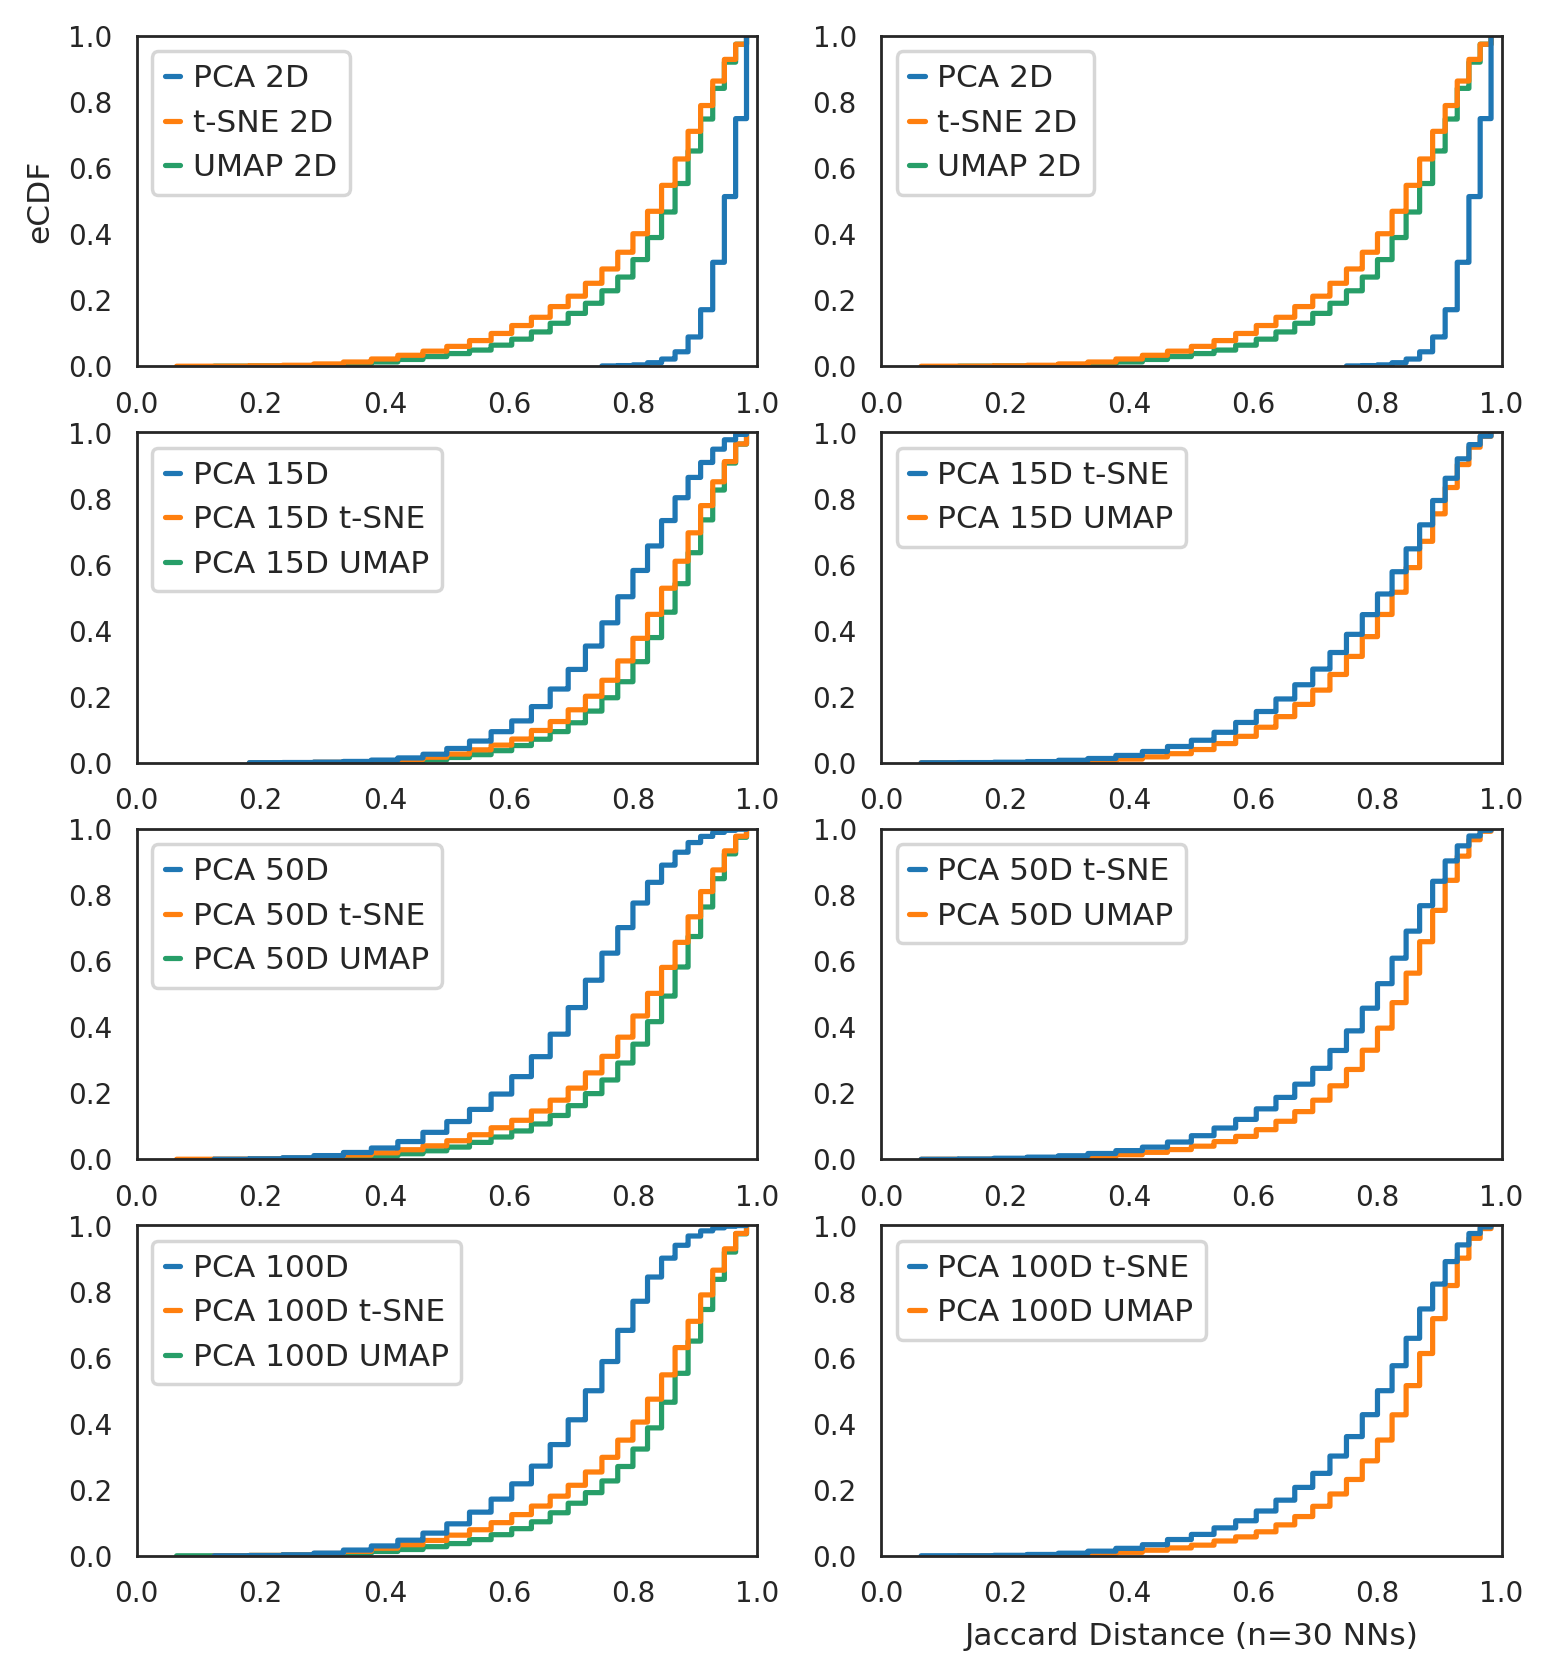

In [ ]:
#merfish data
plotAmb(merAmb,merPCAAmb)

In [ ]:
print(printAvgs(merAmb))
print(printAvgs(merPCAAmb))

{'PCA 100D': 0.7111724239629912, 'PCA 100D UMAP': 0.8281598063189761, 'PCA 100D t-SNE': 0.8014711015580581, 'PCA 15D': 0.7683518913215605, 'PCA 15D UMAP': 0.8414802650399155, 'PCA 15D t-SNE': 0.8228963221338833, 'PCA 2D': 0.9477493024445052, 'PCA 50D': 0.7012991017237619, 'PCA 50D UMAP': 0.8233743183320963, 'PCA 50D t-SNE': 0.7980189175260284, 'UMAP 2D': 0.8276923336140246, 't-SNE 2D': 0.8025145530277004}
{'PCA 100D UMAP': 0.821126771674439, 'PCA 100D t-SNE': 0.7770925222050094, 'PCA 15D UMAP': 0.7984137476526347, 'PCA 15D t-SNE': 0.7733763424104148, 'PCA 50D UMAP': 0.8076987671806775, 'PCA 50D t-SNE': 0.7670194047181272}


In [ ]:
# #tenx data
# plotAmb(tenxAmb,tenxPCAAmb)